## 🔍 1. Бинарная классификация: SpeakerResNetClassifier
#### 🎯 Цель
Модель решает задачу классификации телефонных аудиозаписей живых людей от автоответчиков (голосовых ботов, IVR и пр.).

### 🧠 Архитектура
📥
Вход
Аудиосигнал (8 кГц, до 3 сек)
📊
Предобработка
Mel‑спектрограмма (80 мел‑бинов, hop=64)
🔳
Энкодер
Свёрточная сеть
ResNet29
с остаточными блоками
📤
Выход
Вероятности классов
human
/
smart
через
softmax

### ⭐ Результаты

✅ Точность: 93.2% на тестовой выборке

📏 AUC‑ROC: 0.979 

🎯 Precision (smart): 0.96 — низкий процент ложных срабатываний на голосе человека

🎯 Recall (smart): 0.92 — значительная часть автоответчиков обнаружена

🔌 Применение
💡 Подходит для call‑центров, систем фильтрации звонков и предварительной сортировки аудиотрафика. 



## 🧬 2. Спикер-эмбеддинги: SpeakerEmbedder

#### 🎯 Цель
Модель позволяет оздать компактные, дискриминативные векторы (эмбеддинги), которые:

близки для разных записей одного и того же спикера
далеко друг от друга для разных спикеров
### 🧠 Архитектура

📥
Вход
Аудиосигнал (8 кГц, до 3 сек)

📊
Предобработка
Mel‑спектрограмма (64 мел‑бина, hop=50, f_min=100 Гц)

📣
Аугментации
Speed perturbation, SpecAugment, фоновый шум

🔳
Энкодер
ResNet29
+
SubCenterArcFace (K=2), обучение с помощью loss SubCenterArcFaceLayer

📤
Выход
L2‑нормализованный вектор 256D
, готовый к сравнению


### 🔌 Применение

✅ Верификация / идентификация спикера

✅ Поиск "похожих голосов" (например, поиск известных автоответчиков в базе)

✅ Извлечение признаков для других аудио‑моделей

💡 Эмбеддинги можно использовать как замену классификатору, если автоответчики повторяются (например, типовые IVR). 



In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np

In [199]:
# import pandas as pd

In [200]:
# df = pd.read_csv(r'E://python/train_smart_detect/answering_machine.csv')
# vp = pd.read_excel(r'E://python/train_smart_detect/virtual_helper.xlsx')


In [ ]:
# vp_text = vp['text'].to_list()
# exc_txt = ['ассистент','мия', 'миа','алгоритмы','массив данных','навострила','нейросети','продиктуйте','не волнуйтесь', 
#            'мне нравится слушать и анализировать',
#            'детальное сообщение я ничего не упустила',
#            'все записано понимаете',
#            'информация важная и детальная', 
#            'и я все записала абонент пока не может',
#            'давайте я запишу ваше сообщение', 
#            'алло на связи',
#            'это важное сообщение понимаю я передам', 
#            'пока что у телефона секретарь', 
#            'на связи говорите',
#            'прямо сейчас абонент не может ответить какой вопрос вы хотели обсудить',                                                                     
#            'сейчас абонент занят по какому вопросу вы звоните' ,                                                                                            
#            'на связи',
#            'анализировать человеческую речь',
#            'можете рассказать подробнее я все передам абоненту',
#            'надеюсь с ним все в порядке',
#            'это секретарь что я могу',
#            'сообщите детали пожалуйста я передам их абоненту',
#            'помнила и уже передаю абоненту',
#            'детальное сообщение',
#            'хм абонент пока не сможет поговорить',
#            'если вы поддерживаете домашний интернет то почему не звоните на домашний телефон вы изменяете своим принципам',
#            'простите но абонент сейчас не ответит за то он получит ваше сообщение можете на меня',
#            'какие либо подробности желаете рассказать',      
#            'и уже передаю абоненту это все или хотите еще что то добавить',
#            'все ясно сейчас передам абоненту',
#            'человеческую речь а сейчас я ее не слышу это у меня неполадки или у вас',
#            'это секретарь я запишу и точно передам что вы звонили с вами свяжутся а я пошел играть в пасьянс косынку',
#            'уточните ключевой момент пожалуйста',
#            'алло говорите пожалуйста это мия',
#            'пока не может взять трубку но не расстраивайтесь',
           
#            ]+vp_text



In [ ]:

# # Создаём паттерн для поиска: объединяем все фрагменты через '|'
# pattern = '|'.join(exc_txt)

# # Фильтруем DataFrame: оставляем только строки, где text содержит хотя бы один фрагмент
# filtered_df = df[df['text'].str.contains(pattern, case=False, na=False)]

In [ ]:
# filtered_df['text'].value_counts()[100:150]

text
Алло говорите пожалуйста это мия голосовой ассистент                                                                                                                                     22
И я все записала абонент пока не может взять трубку но не расстраивайтесь по моим расчетам ваше сообщение обязательно увидят                                                             21
Тамия голосовой ассистент                                                                                                                                                                21
Ну вот опять я жду может поразмышлять пока над тем как улучшить свои алгоритмы обработки данных искусственный интеллект уже может создавать музыку и некоторые композиции даже не        21
Это тишина подумать только сейчас в мире уже разрабатываются нейросети способные читать эмоции людей интересно смогу ли я когда нибудь это делать а пока что я тут                       20
Алло это миа голосовой ассистент                       

In [ ]:
# filtered_sessions = filtered_df['conversation_id'].to_list()

In [ ]:
# from pathlib import Path
# import shutil

# # Исходный и целевой каталоги
# src_dir = Path(r"E:/python/train_smart_detect/train/answering_machine/")
# dst_dir = Path(r"E:/python/train_smart_detect/train/virtual_helper/")

# # Убедитесь, что целевая папка существует
# dst_dir.mkdir(parents=True, exist_ok=True)

# # Список паттернов (подстрок), по которым ищем
# # filtered_sessions = ["node_0_domain_0_nauss_0_1752150468_9310913"]

# # Проходим по всем файлам в исходной папке
# for file_path in src_dir.iterdir():
#     if file_path.is_file():
#         filename = file_path.name
#         # Проверяем, содержит ли имя файла хотя бы один паттерн
#         if any(pattern in filename for pattern in filtered_sessions):
#             # Переносим файл
#             shutil.move(str(file_path), str(dst_dir / file_path.name))
#             print(f"Перемещён: {filename}")

In [86]:
# pip install protobuf==6.32.1

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class MelSpectrogram(layers.Layer):
    def __init__(self,
                 sample_rate=8000,
                 n_fft=256,
                 win_length=200,
                 hop_length=80,
                 n_mels=64,
                 f_min=100.0,
                 f_max=3800.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.f_min = f_min
        self.f_max = f_max

        # Создаём mel-фильтры один раз
        self.mel_basis = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.n_mels,
            num_spectrogram_bins=self.n_fft // 2 + 1,
            sample_rate=self.sample_rate,
            lower_edge_hertz=self.f_min,
            upper_edge_hertz=self.f_max
        )
        self.mel_basis = tf.cast(self.mel_basis, tf.float32)


        # Создаём окно Ханна
        # self.window = tf.signal.hann_window(self.win_length, periodic=True)

    def call(self, audio):
        """
        audio: [batch, time] — float32, предполагается в диапазоне [-1, 1]
        Возвращает: [batch, n_mels, T, 1]
        Но: в PyTorch возвращает (1, T, 80), т.е. [batch=1, time, n_mels]
        В TF сделаем [batch, time, n_mels, 1] или [batch, n_mels, time, 1]?
        """

        # Убедимся, что audio — float32
        audio = tf.cast(audio, tf.float32)

        # STFT с окном Ханна и pad_end=True (как в torchaudio по умолчанию)
        stft = tf.signal.stft(
            audio,
            frame_length=self.win_length,
            frame_step=self.hop_length,
            fft_length=self.n_fft,
            # window_fn=lambda frame_length, dtype: self.window,
            window_fn=tf.signal.hann_window,
            pad_end=True
        )  # [batch, frames, fft_bins]

        magnitude = tf.abs(stft)


        power = tf.square(magnitude)

        mel_spec = tf.matmul(power, self.mel_basis)  # [B, frames, n_mels]

        # → Заменяем лог на dB с clipping
        LOG_10 = tf.math.log(10.0)
        
        log_mel_spec = 10.0 * tf.math.log(tf.maximum(mel_spec, 1e-10)) / LOG_10
        log_mel_spec = tf.clip_by_value(log_mel_spec, -80.0, 20.0)
        

        # Транспонируем: [B, frames, n_mels] -> [B, n_mels, frames]
        log_mel_spec = tf.transpose(log_mel_spec, perm=[0, 2, 1])
        log_mel_spec = tf.expand_dims(log_mel_spec, axis=-1)

        return log_mel_spec  # [batch, T, n_mels, 1]

    def get_config(self):
        config = super().get_config()
        config.update({
            "sample_rate": self.sample_rate,
            "n_fft": self.n_fft,
            "win_length": self.win_length,
            "hop_length": self.hop_length,
            "n_mels": self.n_mels,
            "f_min": self.f_min,
            "f_max": self.f_max,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [143]:
def conv_block(x, filters, kernel_size, strides=(1, 1), activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def resnet_block(x, filters, strides=(1, 1)):
    shortcut = x

    # Основной путь
    x = conv_block(x, filters, (3, 3), strides=strides)
    x = conv_block(x, filters, (3, 3), activation=None)

    # Shortcut с downsample, если нужно
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = conv_block(shortcut, filters, (1, 1), strides=strides, activation=None)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def build_resnet29(input_shape):
    inputs = layers.Input(shape=input_shape)  # [n_mels, time, 1]

    # Начальный слой
    x = conv_block(inputs, 32, (3, 3), strides=(1, 1))  # не уменьшаем время сильно

    # Стеки ResNet блоков (всего ~29 свёрточных слоёв)
    # Структура: [3, 4, 6, 3] блоков — как ResNet34, но с меньшими фильтрами
    filters_list = [32, 64, 128, 256]
    # filters_list = [32, 64, 128]
    # filters_list = [64, 64, 128]

    for i, filters in enumerate(filters_list):
        strides = (2, 1) if i > 0 else (1, 1)  # уменьшаем только по частоте, не по времени
        x = resnet_block(x, filters, strides=strides)
        # for _ in range([2, 4, 4, 2][i]):  # общее число блоков
        for _ in range([3, 6, 6, 3][i]):
            x = resnet_block(x, filters)

    # Global stats pooling (часто используется в спикер-эмбеддингах)
    mean = tf.reduce_mean(x, axis=[1, 2])  # [B, C]
    std = tf.math.reduce_std(x, axis=[1, 2])  # [B, C]
    x = tf.concat([mean, std], axis=-1)  # [B, 2*C]

    return Model(inputs, x, name='ResNet29_Encoder')

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

def get_file_paths_and_labels(data_dir):
    """Собирает пути файлов и метки классов"""
    class_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    file_paths = []
    labels = []

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.lower().endswith('.wav'):
                file_paths.append(os.path.join(class_dir, file_name))
                labels.append(idx)

    return file_paths, labels, class_names

MAX_AUDIO_LENGTH = 8000 * 3


def load_audio(file_path):
    """Загружает WAV и конвертирует в float32"""
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)  # [time]
    # Если частота не 8кГц — можно ресэмплировать
    # audio = tfio.audio.resample(audio, sample_rate, 8000)  # если нужно

    audio_len = tf.shape(audio)[0]
    
    # Обрезаем или паддим до фиксированной длины
    if audio_len > MAX_AUDIO_LENGTH:
        # Выбираем случайную начальную позицию
        max_start = audio_len - MAX_AUDIO_LENGTH
        start = tf.random.uniform([], maxval=max_start + 1, dtype=tf.int32)
        audio = audio[start:start + MAX_AUDIO_LENGTH]
    else:
        audio = tf.pad(audio, [[0, MAX_AUDIO_LENGTH -audio_len ]], constant_values=0.0)
    return audio

def create_dataset(file_paths, labels, batch_size=32, shuffle=True, num_classes = 2, buffer_size=1000):
    """Создаёт tf.data.Dataset"""
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size)

    dataset = dataset.map(
        lambda x, y: (load_audio(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
def SpeakerResNetClassifier(
    num_speakers,
    sample_rate=8000,     # 8кГц
    n_fft=256,            # меньше, чем 512 — для 8кГц
    hop_length=64,        # шаг 64 = 8мс
    n_mels=80,
    embedding_dim=256
):
    audio_input = layers.Input(shape=(None,), dtype=tf.float32, name='audio')

    mel_spec = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels
    )(audio_input)
    mel_spec = layers.BatchNormalization()(mel_spec) 

    encoder = build_resnet29(input_shape=(n_mels, None, 1))
    embeddings = encoder(mel_spec)

    embeddings = layers.Dense(embedding_dim, activation=None, name='embedding')(embeddings)
    # embeddings = layers.BatchNormalization()(embeddings)

    logits = layers.Dense(num_speakers, activation='softmax', name='logits')(embeddings)

    model = Model(inputs=audio_input, outputs=logits, name='SpeakerResNet29_Classifier')
    return model, embeddings



In [174]:
# Путь к данным
data_dir = r"E:/python/train_smart_detect/train2"  # каталог с папками

# Получаем пути и метки
file_paths, labels, class_names = get_file_paths_and_labels(data_dir)
num_classes = len(class_names)
labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)
print(f"Найдено классов: {num_classes}, файлов: {len(file_paths)}")

# Разделение на train/val (95/5)
train_files, val_files, train_labels, val_labels = train_test_split(
    file_paths, labels, test_size=0.05, random_state=43, stratify=labels
)


# Разделение на train/test (90/10)
train_files, test_files, train_labels, test_labels = train_test_split(
    train_files, train_labels, test_size=0.1, random_state=43, stratify=train_labels
)


batch_size=32
# Создаём датасеты
train_dataset = create_dataset(train_files, train_labels, batch_size=batch_size, num_classes=num_classes, shuffle=True)
val_dataset = create_dataset(val_files, val_labels, batch_size=batch_size, num_classes=num_classes, shuffle=False)
test_dataset = create_dataset(test_files, test_labels, batch_size=batch_size, num_classes=num_classes, shuffle=False)

# Создаём модель
model, _ = SpeakerResNetClassifier(num_speakers=num_classes, sample_rate=8000, n_fft=256, hop_length=64)

METRICS = [
    'categorical_accuracy',
    tf.keras.metrics.Precision(class_id=1, name='precision_class1'),
    tf.keras.metrics.Recall(class_id=1, name='recall_class1'),
    tf.keras.metrics.AUC(multi_label=False, name='auc')
]

# Компилируем
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=METRICS
)

# Коллбэки
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='train_smart_detect/checkpoint/best_model.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        monitor='val_loss',
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=3,
        min_lr=1e-6
    )
]



Найдено классов: 2, файлов: 89190


In [172]:
del model

In [27]:
len(train_files), len(test_files), len(val_labels)



(76257, 8473, 4460)

In [23]:
class_names

['human', 'smart']

In [175]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
train_labels_int = np.argmax(train_labels, axis=1)  # [0, 1, 1, 0, ...]

# Вычисляем веса
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels_int),
    y=train_labels_int
)
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: 1.172931983880395, 1: 0.8715085714285714}


In [176]:
# Обучение
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=1,
    callbacks=callbacks,
    # class_weight=class_weight_dict
)



2384/2384 [==============================] - 2077s 869ms/step - loss: 0.2499 - categorical_accuracy: 0.9089 - precision_class1: 0.9108 - recall_class1: 0.9326 - auc: 0.9615 - val_loss: 0.2097 - val_categorical_accuracy: 0.9280 - val_precision_class1: 0.9586 - val_recall_class1: 0.9140 - val_auc: 0.9719 - lr: 1.0000e-05


In [ ]:
# Сохраняем модель
# model.save('train_smart_detect/speaker_classifier5.h5')
# model, _ = SpeakerResNetClassifier(num_speakers=num_classes, sample_rate=8000, n_fft=256, hop_length=64)
# model = tf.keras.models.load_model('train_smart_detect/speaker_classifier3.h5', custom_objects={'MelSpectrogram': MelSpectrogram})

In [ ]:
# model2.load_weights('train_smart_detect/checkpoint/best_model.h5')

In [ ]:
def load_raw_pcm(file_path, sample_rate=8000, dtype=tf.int16):
    """
    Загружает сырой PCM-файл и конвертирует в float32 [-1, 1]
    Предполагается: mono, 16-bit signed integer, little-endian
    """
    raw = tf.io.read_file(file_path)  # читаем байты
    
    # Декодируем как int16 (2 байта на сэмпл)
    audio = tf.io.decode_raw(raw, out_type=dtype)  # shape: [N]
    
    # Конвертируем в float32 и нормализуем в [-1, 1]
    if dtype == tf.int16:
        audio = tf.cast(audio, tf.float32) / 32768.0
    elif dtype == tf.int8:
        audio = tf.cast(audio, tf.float32) / 128.0
    else:
        raise ValueError("Поддерживается только int16 или int8")
    
    return audio


test_wav_path = r'E:/python/train_smart_detect/custom_test/hu_node_5_domain_4_nauss_2_1749038267_12963199__reply_002.wav'
audio = load_raw_pcm(test_wav_path) 
audio = tf.expand_dims(audio, axis=0)       # shape: (1, T)
predictions = model.predict(audio)

(class_names[np.argmax(predictions)], np.round(predictions,4), test_wav_path)
# predictions

1/1 [==============================] - 1s 603ms/step


('smart',
 array([[0.0203, 0.9797]], dtype=float32),
 'E:/python/train_smart_detect/custom_test/hu_node_5_domain_4_nauss_2_1749038267_12963199__reply_002.wav')

In [178]:
test_predict = model.predict(test_dataset)

265/265 [==============================] - 48s 181ms/step


In [179]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(test_predict, axis=1))
print(f"Accuracy: {acc:.4f}")

Accuracy: 0.9320


In [180]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(test_labels, axis=1), np.argmax(test_predict, axis=1), 
                          target_names=class_names))

              precision    recall  f1-score   support

       human       0.89      0.95      0.92      3612
       smart       0.96      0.92      0.94      4861

    accuracy                           0.93      8473
   macro avg       0.93      0.93      0.93      8473
weighted avg       0.93      0.93      0.93      8473



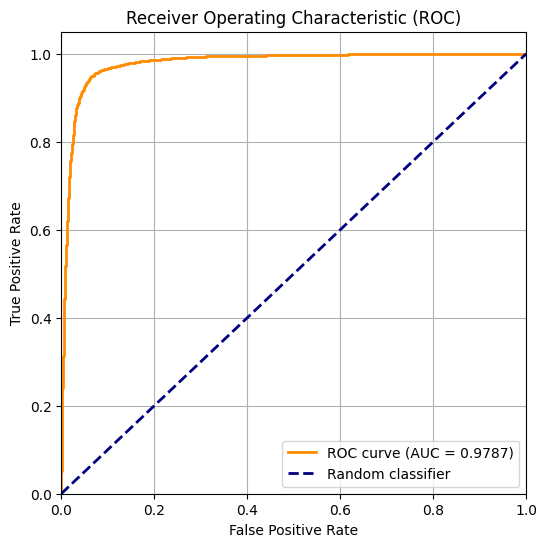

In [182]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Предположим:
# test_labels — one-hot encoded метки (например, [[1,0], [0,1], ...])
# test_predict — выход модели softmax (как в вашем примере)

# Извлекаем истинные метки (0 или 1) из one-hot
y_true = np.argmax(test_labels, axis=1)

# Извлекаем вероятности для положительного класса (класс 1)
y_scores = test_predict[:, 1]  # второй столбец = P(класс=1)

# Вычисляем ROC-кривую и AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Строим график
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
y_pred_proba = model.predict(test_dataset)  # shape: (N, 2)


265/265 [==============================] - 47s 178ms/step


              precision    recall  f1-score   support

       human       0.89      0.95      0.92      3612
       smart       0.96      0.92      0.94      4861

    accuracy                           0.93      8473
   macro avg       0.93      0.93      0.93      8473
weighted avg       0.93      0.93      0.93      8473



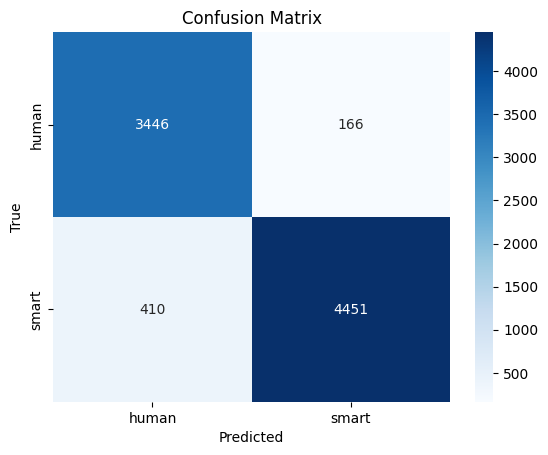

In [202]:
y_pred_smart = test_predict[:, 1]  # вероятность класса 'smart'

threshold = 0.5
y_pred = (y_pred_smart >= threshold).astype(int)

# Теперь оценим:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=['human', 'smart']))

# Истинные метки: из one-hot в классы (0 или 1)
y_true = np.argmax(test_labels, axis=1)  # shape: (N,)

# Предсказанные метки: УЖЕ в виде 0/1 (1D массив)
y_pred = (y_pred_smart >= threshold).astype(int)  # shape: (N,)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Визуализация
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

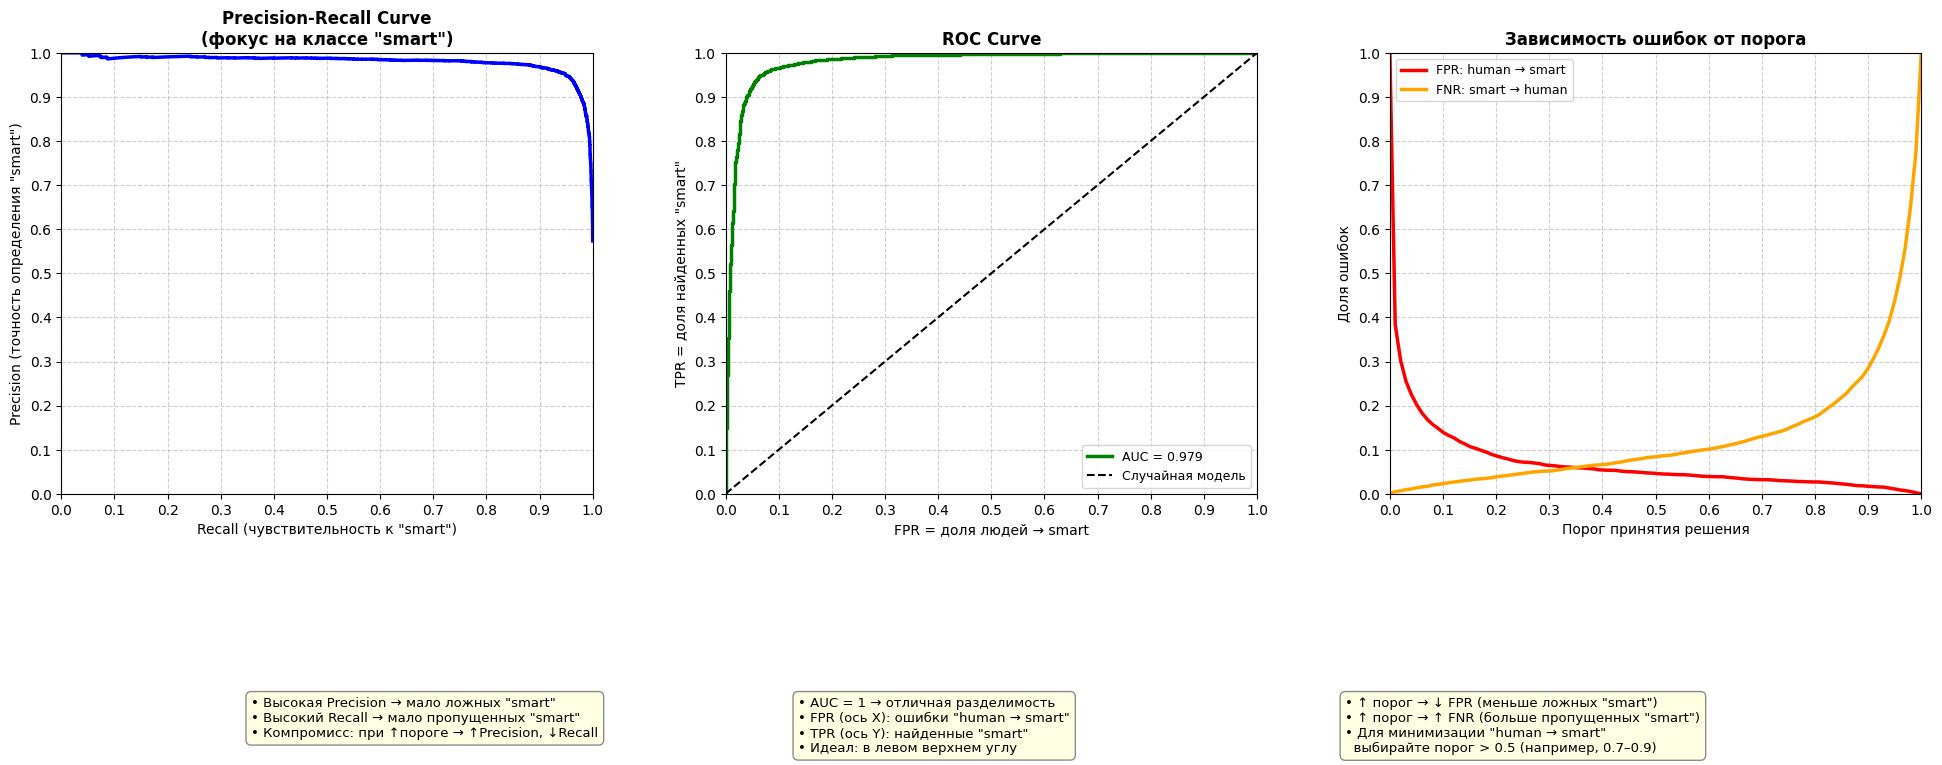

In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# ----------------------------------------------------
# Подготовка данных (предполагается, что y_true и y_pred_smart уже определены)
# ----------------------------------------------------
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred_smart)
fpr, tpr, thresholds_roc = roc_curve(y_true, y_pred_smart)
roc_auc = auc(fpr, tpr)

unique_thresholds = np.linspace(0, 1, 100)
fpr_list = []
fnr_list = []

for th in unique_thresholds:
    y_pred_th = (y_pred_smart >= th).astype(int)
    fp = np.sum((y_true == 0) & (y_pred_th == 1))
    tn = np.sum((y_true == 0) & (y_pred_th == 0))
    fn = np.sum((y_true == 1) & (y_pred_th == 0))
    tp = np.sum((y_true == 1) & (y_pred_th == 1))
    fpr_val = fp / (fp + tn + 1e-8)
    fnr_val = fn / (fn + tp + 1e-8)
    fpr_list.append(fpr_val)
    fnr_list.append(fnr_val)

fpr_list = np.array(fpr_list)
fnr_list = np.array(fnr_list)

# ----------------------------------------------------
# Создаём фигуру с 3 графиками и подписями ПОД ними
# ----------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# ---- График 1: Precision-Recall ----
ax1 = axes[0]
ax1.plot(recall, precision, color='blue', linewidth=2.5)
ax1.set_title('Precision-Recall Curve\n(фокус на классе "smart")', fontsize=12, fontweight='bold')
ax1.set_xlabel('Recall (чувствительность к "smart")', fontsize=10)
ax1.set_ylabel('Precision (точность определения "smart")', fontsize=10)
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.set_xticks(np.arange(0, 1.1, 0.1))
ax1.set_yticks(np.arange(0, 1.1, 0.1))

# ---- График 2: ROC ----
ax2 = axes[1]
ax2.plot(fpr, tpr, color='green', linewidth=2.5, label=f'AUC = {roc_auc:.3f}')
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Случайная модель')
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.set_xlabel('FPR = доля людей → smart', fontsize=10)
ax2.set_ylabel('TPR = доля найденных "smart"', fontsize=10)
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.set_xticks(np.arange(0, 1.1, 0.1))
ax2.set_yticks(np.arange(0, 1.1, 0.1))
ax2.legend(loc='lower right', fontsize=9)

# ---- График 3: FPR/FNR vs порог ----
ax3 = axes[2]
ax3.plot(unique_thresholds, fpr_list, label='FPR: human → smart', color='red', linewidth=2.5)
ax3.plot(unique_thresholds, fnr_list, label='FNR: smart → human', color='orange', linewidth=2.5)
ax3.set_title('Зависимость ошибок от порога', fontsize=12, fontweight='bold')
ax3.set_xlabel('Порог принятия решения', fontsize=10)
ax3.set_ylabel('Доля ошибок', fontsize=10)
ax3.grid(True, linestyle='--', alpha=0.6)
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.set_xticks(np.arange(0, 1.1, 0.1))
ax3.set_yticks(np.arange(0, 1.1, 0.1))
ax3.legend(loc='upper left', fontsize=9)

# ----------------------------------------------------
# Добавляем подписи-капшны ПОД каждым графиком
# ----------------------------------------------------
# Функция для добавления текстового блока под графиком
def add_caption(ax, text, x_offset=0.0):
    bbox = dict(boxstyle="round,pad=0.4", facecolor="lightyellow", edgecolor="gray", alpha=0.9)
    fig.text(
        ax.get_position().x0 + x_offset,
        ax.get_position().y0 - 0.15,  # смещение вниз от графика
        text,
        fontsize=9.5,
        ha='left',
        va='top',
        bbox=bbox,
        wrap=True
    )

# Подписи под графиками
caption1 = (
    "• Высокая Precision → мало ложных \"smart\"\n"
    "• Высокий Recall → мало пропущенных \"smart\"\n"
    "• Компромисс: при ↑пороге → ↑Precision, ↓Recall"
)

caption2 = (
    "• AUC = 1 → отличная разделимость\n"
    "• FPR (ось X): ошибки \"human → smart\"\n"
    "• TPR (ось Y): найденные \"smart\"\n"
    "• Идеал: в левом верхнем углу"
)

caption3 = (
    "• ↑ порог → ↓ FPR (меньше ложных \"smart\")\n"
    "• ↑ порог → ↑ FNR (больше пропущенных \"smart\")\n"
    "• Для минимизации \"human → smart\"\n"
    "  выбирайте порог > 0.5 (например, 0.7–0.9)"
)

add_caption(ax1, caption1, x_offset=0.02)
add_caption(ax2, caption2, x_offset=0.02)
add_caption(ax3, caption3, x_offset=0.02)

# Убираем лишнее пространство — плотная компоновка
plt.subplots_adjust(left=0.05, right=0.98, top=0.88, bottom=0.25, wspace=0.25)

plt.show()

In [186]:
th = 0.5
y_pred_th = (y_pred_smart >= th).astype(int)

# human → smart (FP: модель сказала "smart", а на самом деле "human")
fp = np.sum((y_true == 0) & (y_pred_th == 1))
tn = np.sum((y_true == 0) & (y_pred_th == 0))
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

# smart → human (FN: модель сказала "human", а на самом деле "smart")
fn = np.sum((y_true == 1) & (y_pred_th == 0))
tp = np.sum((y_true == 1) & (y_pred_th == 1))
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0.0

# Вывод
print(f"При пороге {th}:")
print(f"  ❌ human → smart: {fp} ошибок из {fp + tn} человек → FPR = {fpr:.3%}")
print(f"  ❌ smart → human: {fn} ошибок из {fn + tp} smart-устройств → FNR = {fnr:.3%}")
print(f"  ✅ Общая точность: {(tp + tn) / len(y_true):.3%}")

При пороге 0.5:
  ❌ human → smart: 166 ошибок из 3612 человек → FPR = 4.596%
  ❌ smart → human: 410 ошибок из 4861 smart-устройств → FNR = 8.434%
  ✅ Общая точность: 93.202%


🧪 Тестовая выборка: 4861 smart (class=1), 3612 human (class=0)

🔍 Тест на test-выборке | Длительность: 1.0 сек (FAR ≤ 1.0%)...
  → Порог: 0.9765 | FAR: 0.0100 | FRR: 0.6727 | Precision: 0.9779

🔍 Тест на test-выборке | Длительность: 1.5 сек (FAR ≤ 1.0%)...
  → Порог: 0.9653 | FAR: 0.0100 | FRR: 0.5892 | Precision: 0.9823

🔍 Тест на test-выборке | Длительность: 2.0 сек (FAR ≤ 1.0%)...
  → Порог: 0.9513 | FAR: 0.0100 | FRR: 0.5314 | Precision: 0.9844

🔍 Тест на test-выборке | Длительность: 2.5 сек (FAR ≤ 1.0%)...
  → Порог: 0.9663 | FAR: 0.0100 | FRR: 0.5814 | Precision: 0.9826

🔍 Тест на test-выборке | Длительность: 3.0 сек (FAR ≤ 1.0%)...
  → Порог: 0.9550 | FAR: 0.0100 | FRR: 0.5063 | Precision: 0.9852

📊 РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ
Длит.  Порог    FAR      FRR      Precision   TP       FP      
1.0    0.9765   0.0100   0.6727   0.9779      1591     36      
1.5    0.9653   0.0100   0.5892   0.9823      1997     36      
2.0    0.9513   0.0100   0.5314   0.9844      2278     36    

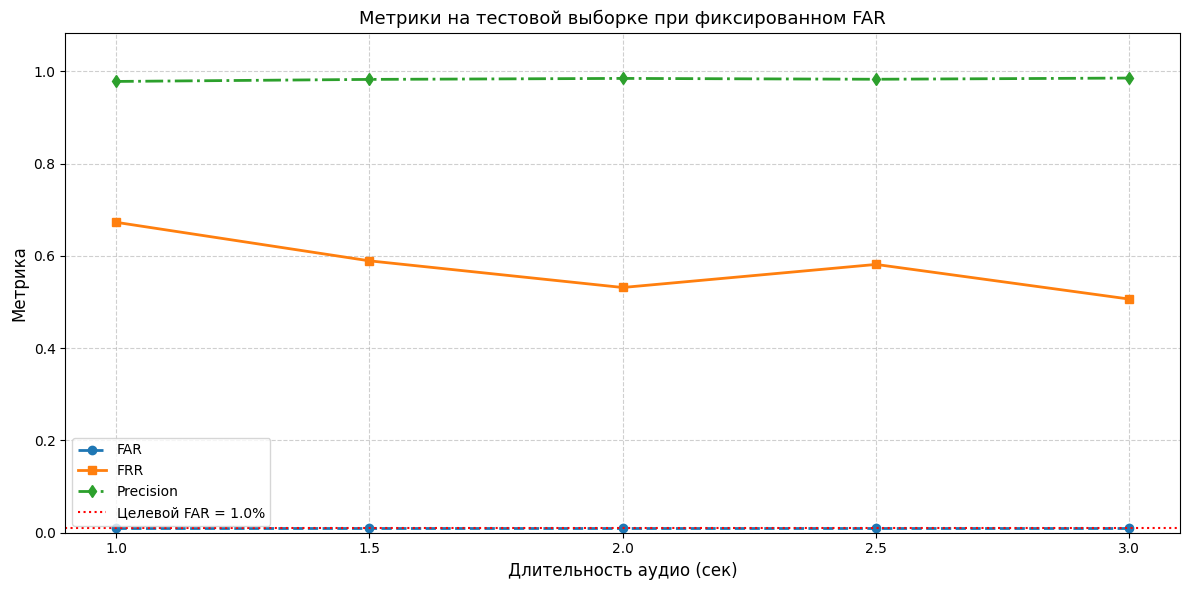

In [ ]:
# === ЗАГРУЗКА МОДЕЛИ  ===
# model = tf.keras.models.load_model('train_smart_detect/checkpoint/best_model.h5')

# === ПОДГОТОВКА ТЕСТОВЫХ ДАННЫХ ===
# Преобразуем OHE метки обратно в целые числа
test_labels_int = np.argmax(test_labels, axis=1)  # [0, 1, 1, 0, ...]

# Определяем, какие файлы — позитивы (smart = 1), какие — негативы (human = 0)
pos_test_files = [f for f, lab in zip(test_files, test_labels_int) if lab == 1]
neg_test_files = [f for f, lab in zip(test_files, test_labels_int) if lab == 0]

print(f"🧪 Тестовая выборка: {len(pos_test_files)} smart (class=1), {len(neg_test_files)} human (class=0)")

# === НАСТРОЙКИ ТЕСТА ===
SAMPLE_RATE = 8000
DURATIONS_SEC = [1.0, 1.5, 2.0, 2.5, 3.0]
DURATIONS_SAMPLES = [int(d * SAMPLE_RATE) for d in DURATIONS_SEC]
TARGET_FAR = 0.01  # 1%

# === ФУНКЦИЯ ЗАГРУЗКИ АУДИО ФИКСИРОВАННОЙ ДЛИНЫ ===
def load_audio_to_fixed_length(file_path, target_length):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.where(tf.math.is_finite(audio), audio, 0.0)
    audio = tf.clip_by_value(audio, -1.0, 1.0)
    current_len = tf.shape(audio)[0]
    if current_len >= target_length:
        audio = audio[:target_length]
    else:
        pad_len = target_length - current_len
        audio = tf.pad(audio, [[0, pad_len]], constant_values=0.0)
    return audio

# === ПОЛУЧЕНИЕ ВЕРОЯТНОСТЕЙ ДЛЯ ЗАДАННОЙ ДЛИНЫ ===
def get_probabilities_for_duration(file_paths, model, target_length, batch_size=32):
    probs = []
    for i in range(0, len(file_paths), batch_size):
        batch = file_paths[i:i + batch_size]
        audios = tf.stack([load_audio_to_fixed_length(fp, target_length) for fp in batch])
        preds = model(audios, training=False).numpy()  # [B, 2]
        probs.append(preds[:, 1])  # вероятность класса 1 (smart)
    return np.concatenate(probs)

# === ОСНОВНОЙ ЦИКЛ ПО ДЛИТЕЛЬНОСТЯМ ===
results_test = []

all_test_files = test_files
true_test_labels = test_labels_int  # уже целые числа

for dur_sec, dur_samples in zip(DURATIONS_SEC, DURATIONS_SAMPLES):
    print(f"\n🔍 Тест на test-выборке | Длительность: {dur_sec:.1f} сек (FAR ≤ {TARGET_FAR:.1%})...")

    probs = get_probabilities_for_duration(all_test_files, model, dur_samples, batch_size=32)

    # Сортируем по убыванию вероятности
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_labels = true_test_labels[sorted_indices]

    n_neg = len(neg_test_files)
    max_fp_allowed = int(np.floor(TARGET_FAR * n_neg))

    # Поиск порога
    fp_count = 0
    best_idx = 0
    for i, label in enumerate(sorted_labels):
        if label == 0:
            fp_count += 1
        if fp_count > max_fp_allowed:
            best_idx = i
            break
    else:
        best_idx = len(sorted_labels)

    if best_idx == 0:
        threshold = 1.0
        tp = fp = 0
    else:
        threshold = sorted_probs[best_idx - 1]
        preds = (probs >= threshold).astype(int)
        tp = np.sum((preds == 1) & (true_test_labels == 1))
        fp = np.sum((preds == 1) & (true_test_labels == 0))

    tn = len(neg_test_files) - fp
    fn = len(pos_test_files) - tp

    far = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    frr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    results_test.append({
        'duration_sec': dur_sec,
        'threshold': threshold,
        'far': far,
        'frr': frr,
        'precision': precision,
        'accuracy': accuracy,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
    })

    print(f"  → Порог: {threshold:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | Precision: {precision:.4f}")

# === ВЫВОД ТАБЛИЦЫ ===
print("\n" + "="*100)
print("📊 РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")
print(f"{'Длит.':<6} {'Порог':<8} {'FAR':<8} {'FRR':<8} {'Precision':<11} {'TP':<8} {'FP':<8}")
print("="*100)
for r in results_test:
    print(f"{r['duration_sec']:<6} {r['threshold']:<8.4f} {r['far']:<8.4f} {r['frr']:<8.4f} "
          f"{r['precision']:<11.4f} {r['tp']:<8} {r['fp']:<8}")

# === ГРАФИК ===
import matplotlib.pyplot as plt

durs = [r['duration_sec'] for r in results_test]
fars = [r['far'] for r in results_test]
frrs = [r['frr'] for r in results_test]
precisions = [r['precision'] for r in results_test]

plt.figure(figsize=(12, 6))
plt.plot(durs, fars, 'o--', label='FAR', linewidth=2)
plt.plot(durs, frrs, 's-', label='FRR', linewidth=2)
plt.plot(durs, precisions, 'd-.', label='Precision', linewidth=2)
plt.axhline(y=TARGET_FAR, color='red', linestyle=':', label=f'Целевой FAR = {TARGET_FAR:.1%}')
plt.xlabel('Длительность аудио (сек)', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.title('Метрики на тестовой выборке при фиксированном FAR', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(durs)
plt.ylim(0, max(0.5, max(frrs + precisions) * 1.1))
plt.tight_layout()
plt.show()

In [189]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Загрузи аудио вручную (как в датасете)
# audio_binary = tf.io.read_file(test_wav_path)
# audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
# audio = tf.squeeze(audio, axis=-1)  # [T]
# audio = tf.expand_dims(audio, axis=0)  # [1, T] — batch dim


audio = load_raw_pcm(test_wav_path)
audio = tf.expand_dims(audio, axis=0)  # [1, T] — batch dim
print("Аудио shape:", audio.shape)
print("Длительность:", audio.shape[1] / 8000, "сек")

Аудио shape: (1, 34022)
Длительность: 4.25275 сек


In [191]:
# Создаём экземпляр твоего слоя с теми же параметрами, что и в модели
mel_layer = MelSpectrogram(
    sample_rate=8000,
    n_fft=256,
    hop_length=64,
    n_mels=80,
    f_min=100,
    f_max=3800  # для 8кГц максимум 4кГц
)

# Получаем mel-спектрограмму
mel_spec = mel_layer(audio)  # [1, n_mels, time, 1]
mel_spec = layers.BatchNormalization()(mel_spec) 
# Убираем batch и channel dims для визуализации
mel_spec_np = tf.squeeze(mel_spec, axis=[0, -1]).numpy()  # [n_mels, time]

print("Mel-спектрограмма shape:", mel_spec_np.shape)

Mel-спектрограмма shape: (80, 532)


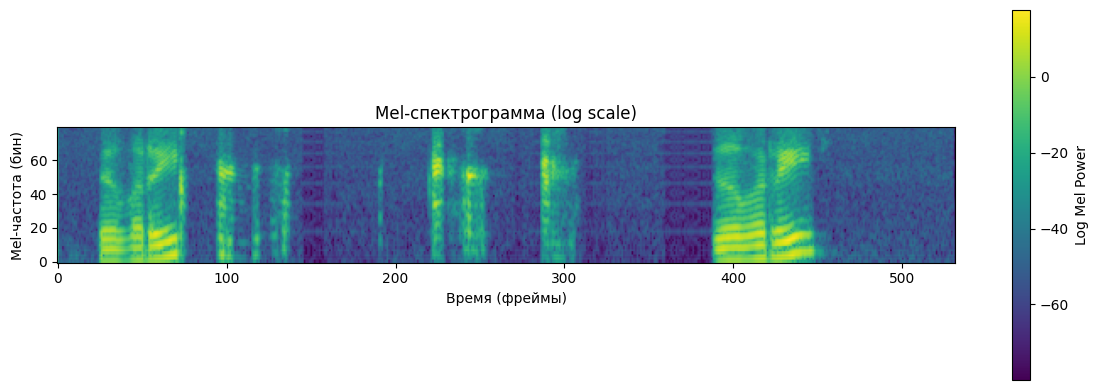

In [192]:
plt.figure(figsize=(12, 4))
# mel_spec_np: [частота (mel), время]
# Для imshow нужно: [время, частота] → транспонируем
# plt.imshow(mel_spec_np, aspect='auto', origin='lower', cmap='magma')
plt.imshow(mel_spec_np, origin='lower')
plt.colorbar(label='Log Mel Power')
plt.xlabel('Время (фреймы)')
plt.ylabel('Mel-частота (бин)')
plt.title('Mel-спектрограмма (log scale)')
plt.tight_layout()
plt.show()

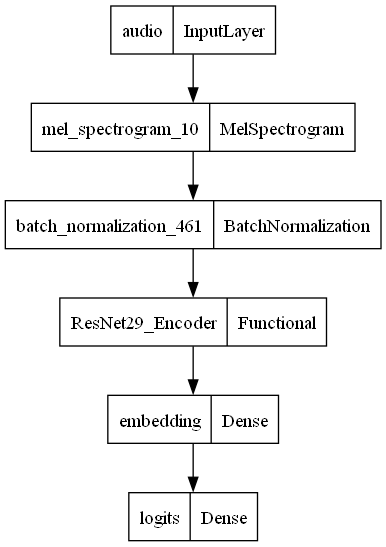

In [194]:
tf.keras.utils.plot_model(model)

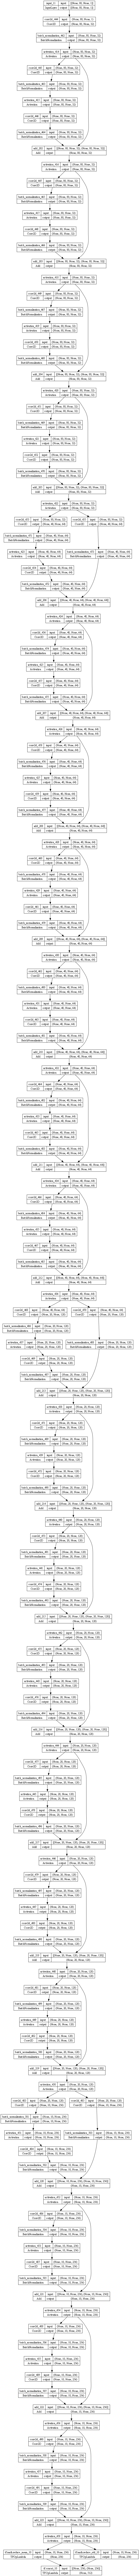

In [196]:
tf.keras.utils.plot_model(
    model.layers[3],
    to_file='resnet29_encoder.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',  # 'TB' = top to bottom, 'LR' = left to right
    expand_nested=False,
    dpi=64
)

# EMBEDDING TRAIN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import os

from sklearn.model_selection import train_test_split



In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [ ]:


class MelSpectrogram(layers.Layer):
    def __init__(self,
                 sample_rate=8000,
                 n_fft=256,
                 win_length=200,
                 hop_length=64,
                 n_mels=80,
                 f_min=20.0,
                 f_max=4000.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.sample_rate = sample_rate
        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.f_min = f_min
        self.f_max = f_max

        # Создаём mel-фильтры один раз
        self.mel_basis = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.n_mels,
            num_spectrogram_bins=self.n_fft // 2 + 1,
            sample_rate=self.sample_rate,
            lower_edge_hertz=self.f_min,
            upper_edge_hertz=self.f_max
        )
        self.mel_basis = tf.cast(self.mel_basis, tf.float32)


    def call(self, audio):
        """
        audio: [batch, time] — float32, предполагается в диапазоне [-1, 1]
        Возвращает: [batch, n_mels, T, 1]
        Но: в PyTorch возвращает (1, T, 80), т.е. [batch=1, time, n_mels]
        В TF сделаем [batch, time, n_mels, 1] или [batch, n_mels, time, 1]?
        """

        # Убедимся, что audio — float32
        audio = tf.cast(audio, tf.float32)

        # STFT с окном Ханна и pad_end=True
        stft = tf.signal.stft(
            audio,
            frame_length=self.win_length,
            frame_step=self.hop_length,
            fft_length=self.n_fft,
            # window_fn=lambda frame_length, dtype: self.window,
            window_fn=tf.signal.hann_window,
            pad_end=True
        )  # [batch, frames, fft_bins]

        magnitude = tf.abs(stft)


        power = tf.square(magnitude)

        mel_spec = tf.matmul(power, self.mel_basis)  # [B, frames, n_mels]

        # → Заменяем лог на dB с clipping
        LOG_10 = tf.math.log(10.0)
        
        log_mel_spec = 10.0 * tf.math.log(tf.maximum(mel_spec, 1e-10)) / LOG_10
        log_mel_spec = tf.clip_by_value(log_mel_spec, -80.0, 20.0)        

        # Транспонируем: [B, frames, n_mels] -> [B, n_mels, frames]
        log_mel_spec = tf.transpose(log_mel_spec, perm=[0, 2, 1])
        log_mel_spec = tf.expand_dims(log_mel_spec, axis=-1)

        return log_mel_spec  # [batch, T, n_mels, 1]

    def get_config(self):
        config = super().get_config()
        config.update({
            "sample_rate": self.sample_rate,
            "n_fft": self.n_fft,
            "win_length": self.win_length,
            "hop_length": self.hop_length,
            "n_mels": self.n_mels,
            "f_min": self.f_min,
            "f_max": self.f_max,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)



In [ ]:
def conv_block(x, filters, kernel_size, strides=(1, 1), activation='relu'):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False,  kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    if activation:
        x = layers.Activation(activation)(x)
    return x

def resnet_block(x, filters, strides=(1, 1)):
    shortcut = x

    # Основной путь
    x = conv_block(x, filters, (3, 3), strides=strides)
    x = conv_block(x, filters, (3, 3), activation=None)

    # Shortcut с downsample, если нужно
    if strides != (1, 1) or shortcut.shape[-1] != filters:
        shortcut = conv_block(shortcut, filters, (1, 1), strides=strides, activation=None)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_resnet29(input_shape):
    inputs = layers.Input(shape=input_shape)  # [n_mels, time, 1]

    # Начальный слой
    x = conv_block(inputs, 32, (3, 3), strides=(1, 1))  # не уменьшаем время сильно

    # Стеки ResNet блоков
    # Структура: [3, 4, 6, 3] блоков — как ResNet34    
    filters_list = [32, 64, 128, 256]  

    for i, filters in enumerate(filters_list):
        strides = (2, 1) if i > 0 else (1, 1)  # уменьшаем только по частоте, не по времени
        x = resnet_block(x, filters, strides=strides)
        # for _ in range([8, 2, 3, 2][i]):  # общее число блоков ≈ 29 слоёв  
        for _ in range([3, 6, 6, 3][i]):  # общее число блоков ≈ 29 слоёв     
            x = resnet_block(x, filters)

    # Global stats pooling (часто используется в спикер-эмбеддингах)
    mean = tf.reduce_mean(x, axis=[1, 2])
    var = tf.reduce_mean(tf.square(x - tf.expand_dims(tf.expand_dims(mean, 1), 1)), axis=[1, 2])
    std = tf.sqrt(var + 1e-8)  # +eps для стабильности
    x = tf.concat([mean, std], axis=-1)  # [B, 2*C]    

    return Model(inputs, x, name='ResNet29_Encoder')


In [ ]:


def get_file_paths_and_labels(data_dir):
    """Собираем пути файлов и метки классов"""

    list_dir = os.listdir(data_dir)

    class_names = sorted([d for d in list_dir if os.path.isdir(os.path.join(data_dir, d))])
    file_paths = []
    labels = []

    for idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            if file_name.lower().endswith('.wav'):
                file_paths.append(os.path.join(class_dir, file_name))
                labels.append(idx)

    return file_paths, labels, class_names

MAX_AUDIO_LENGTH = 8000 * 3


def apply_reverb(audio, reverb_strength=0.2, decay=0.5):
    """
    Простая эмуляция реверберации через затухающий хвост.
    audio: [T]
    reverb_strength: сила реверберации (0 – нет, 1 – сильная)
    decay: скорость затухания (0.1–0.9)
    """
    audio = tf.cast(audio, tf.float32)
    length = tf.shape(audio)[0]

    # Создаём затухающий импульс (например, длиной 10 мс = 80 сэмплов при 8 кГц)
    reverb_len = tf.minimum(80, length)  # не больше длины сигнала
    decay_filter = tf.exp(-tf.range(tf.cast(reverb_len, tf.float32)) / (decay * 50.0))
    decay_filter = decay_filter / tf.reduce_sum(decay_filter)  # нормируем

    # Свёртка через tf.nn.conv1d (предварительно reshape)
    audio_padded = tf.pad(audio, [[reverb_len - 1, 0]], mode='constant')
    audio_reshaped = tf.reshape(audio_padded, [1, -1, 1])
    kernel = tf.reshape(decay_filter, [-1, 1, 1])

    reverb_audio = tf.nn.conv1d(audio_reshaped, kernel, stride=1, padding='VALID')
    reverb_audio = tf.squeeze(reverb_audio)

    # Микс оригинала и реверберированного сигнала
    return (1.0 - reverb_strength) * audio + reverb_strength * reverb_audio


def apply_distortion(audio, distortion_gain=2.0):
    """
    Применяет нелинейное насыщение (дисторшн).
    distortion_gain > 1 усиливает сигнал перед насыщением.
    """
    audio = audio * distortion_gain
    # tanh (мягкое насыщение)
    audio = tf.tanh(audio)    
    return audio


def augment_audio(audio, sample_rate=8000):
    """
    Применяет аугментации к аудиосигналу.
    audio: [time] — float32, [-1, 1]
    """
    # Speed perturbation (самая важная для спикеров)
    if tf.random.uniform([]) > 0.3:
        speed_factor = tf.random.uniform([], 0.85, 1.15)  # ±15% скорости
        
        # Изменяем длину через интерполяцию
        original_length = tf.shape(audio)[0]
        new_length = tf.cast(tf.cast(original_length, tf.float32) * speed_factor, tf.int32)
        
        # Простая интерполяция: растягиваем/сжимаем сигнал
        audio = tf.image.resize(
            tf.reshape(audio, [1, -1, 1]),  # [1, length, 1]
            [1, new_length],
            method='bilinear'
        )
        audio = tf.reshape(audio, [-1])  # [new_length]
        
        # Обрезаем или дополняем до оригинальной длины
        if new_length > original_length:
            audio = audio[:original_length]
        else:
            audio = tf.pad(audio, [[0, original_length - new_length]])
    
    # Reverb (с вероятностью 30%)
    if tf.random.uniform([]) < 0.3:
        reverb_strength = tf.random.uniform([], 0.05, 0.25)
        decay = tf.random.uniform([], 0.3, 0.7)
        audio = apply_reverb(audio, reverb_strength=reverb_strength, decay=decay)

    # Distortion (с вероятностью 20%)
    # if tf.random.uniform([]) < 0.2:
    #     gain = tf.random.uniform([], 1.5, 3.0)
    #     audio = apply_distortion(audio, distortion_gain=gain)


    # 1. Additive noise (белый шум)
    noise = tf.random.normal(tf.shape(audio), stddev=0.005)  # тихий шум
    audio = audio + noise

    # 2. Volume perturbation (случайное изменение громкости)
    gain = tf.random.uniform([], minval=0.7, maxval=1.3)
    audio = audio * gain

    # Ограничение диапазона
    audio = tf.clip_by_value(audio, -1.0, 1.0)
    return audio



def load_audio(file_path, augment=False):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)  # [time]

    # Защита от некорректных значений
    audio = tf.where(tf.math.is_finite(audio), audio, 0.0)
    audio = tf.clip_by_value(audio, -1.0, 1.0)

    # Получаем длину как Python int (eager-режим!)
    audio_len = int(audio.shape[0])  
    # audio_len = tf.shape(audio)[0]
#
    if audio_len > MAX_AUDIO_LENGTH:
        max_start = audio_len - MAX_AUDIO_LENGTH
        start = np.random.randint(0, max_start + 1)  # ← используем numpy
        audio = audio[start:start + MAX_AUDIO_LENGTH]
    else:
        pad_len = MAX_AUDIO_LENGTH - audio_len
        audio = tf.pad(audio, [[0, pad_len]], constant_values=0.0)

    if augment:
        audio = augment_audio(audio)
    
    return audio 


def load_audio_eager(file_path, augment=False):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)

    audio = tf.where(tf.math.is_finite(audio), audio, 0.0)
    audio = tf.clip_by_value(audio, -1.0, 1.0)

    # Eager: shape известна
    audio_len = int(audio.shape[0])
    if audio_len > MAX_AUDIO_LENGTH:
        start = np.random.randint(0, audio_len - MAX_AUDIO_LENGTH + 1)
        audio = audio[start:start + MAX_AUDIO_LENGTH]
    else:
        audio = tf.pad(audio, [[0, MAX_AUDIO_LENGTH - audio_len]], constant_values=0.0)

    if augment:
        audio = augment_audio(audio)
    return audio
    

def load_audio_graph(file_path, augment=False):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)

    audio = tf.where(tf.math.is_finite(audio), audio, 0.0)
    audio = tf.clip_by_value(audio, -1.0, 1.0)

    # Граф: используем tf.shape и tf.cond
    audio_len = tf.shape(audio)[0]

    def trim():
        max_start = audio_len - MAX_AUDIO_LENGTH
        max_start = tf.maximum(max_start, 0)
        start = tf.random.uniform([], maxval=max_start + 1, dtype=tf.int32)
        return audio[start:start + MAX_AUDIO_LENGTH]

    def pad():
        pad_len = MAX_AUDIO_LENGTH - audio_len
        return tf.pad(audio, [[0, pad_len]], constant_values=0.0)

    audio = tf.cond(audio_len > MAX_AUDIO_LENGTH, trim, pad)

    if augment:
        audio = augment_audio(audio)
    return audio



def create_dataset(file_paths, labels, batch_size=32, shuffle=True, augment=False, buffer_size=1000):
    """Создаёт tf.data.Dataset"""
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size)

    dataset = dataset.map(
        lambda x, y: (load_audio(x, augment=augment), y),
        num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)  # ← не padded_batch!

    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


In [ ]:

class SpecAugmentLayer(layers.Layer):
    def __init__(self,
                 freq_mask_prob=0.5,
                 time_mask_prob=0.5,
                 freq_mask_width=27,
                 time_mask_width=100,
                 **kwargs):
        super().__init__(**kwargs)
        self.freq_mask_prob = freq_mask_prob
        self.time_mask_prob = time_mask_prob
        self.freq_mask_width = freq_mask_width
        self.time_mask_width = time_mask_width

    def call(self, inputs, training=None):
        if not training:
            return inputs
        
        mel_spec = tf.squeeze(inputs, axis=-1)  # [B, F, T]
        
        # Применяем частотную маску с вероятностью freq_mask_prob
        mel_spec = tf.cond(
            tf.random.uniform([]) < self.freq_mask_prob,
            lambda: self._apply_frequency_mask(mel_spec),
            lambda: mel_spec
        )
        
        # Применяем временную маску с вероятностью time_mask_prob
        mel_spec = tf.cond(
            tf.random.uniform([]) < self.time_mask_prob,
            lambda: self._apply_time_mask(mel_spec),
            lambda: mel_spec
        )
        
        return tf.expand_dims(mel_spec, axis=-1)

    def _apply_frequency_mask(self, mel_spec):
        B, F, T = tf.shape(mel_spec)[0], tf.shape(mel_spec)[1], tf.shape(mel_spec)[2]
        max_width = tf.minimum(self.freq_mask_width, F)

        def apply_to_one(spec):
            width = tf.random.uniform([], maxval=max_width, dtype=tf.int32)
            start = tf.random.uniform([], maxval=F - width + 1, dtype=tf.int32)
            end = start + width
            mask = tf.range(F) < start  # [F]
            mask = tf.logical_or(mask, tf.range(F) >= end)
            mask = tf.cast(mask, mel_spec.dtype)
            return spec * mask[:, None]  # [F, T]

        return tf.map_fn(apply_to_one, mel_spec, fn_output_signature=mel_spec.dtype)

    def _apply_time_mask(self, mel_spec):
        B, F, T = tf.shape(mel_spec)[0], tf.shape(mel_spec)[1], tf.shape(mel_spec)[2]
        max_width = tf.minimum(self.time_mask_width, T)

        def apply_to_one(spec):
            width = tf.random.uniform([], maxval=max_width, dtype=tf.int32)
            start = tf.random.uniform([], maxval=T - width + 1, dtype=tf.int32)
            end = start + width
            mask = tf.range(T) < start
            mask = tf.logical_or(mask, tf.range(T) >= end)
            mask = tf.cast(mask, mel_spec.dtype)
            return spec * mask[None, :]  # [F, T]

        return tf.map_fn(apply_to_one, mel_spec, fn_output_signature=mel_spec.dtype)

    def get_config(self):
        return {
            "freq_mask_prob": self.freq_mask_prob,
            "time_mask_prob": self.time_mask_prob,
            "freq_mask_width": self.freq_mask_width,
            "time_mask_width": self.time_mask_width,
        }



def SpeakerEmbedder(
    sample_rate: int = 8000,
    n_fft: int = 256,
    win_length: int = 200,
    hop_length: int = 80,
    n_mels: int = 64,
    embedding_dim: int = 256,
    f_min: int = 300,
    f_max: int = 3800,
    name: str = "SpeakerEmbedder",
   
) -> tuple[Model, Model]:
    """
    Создаёт две модели из одного графа:
      - training_model: возвращает сырой эмбеддинг (для ArcFace)
      - embedder_model: возвращает L2-нормализованный эмбеддинг (для инференса/EER)
    """
    # Вход
    audio_input = layers.Input(shape=(None,), dtype=tf.float32, name="audio")

    # Mel-спектрограмма
    mel_spec = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mels,
        f_min=f_min,
        f_max=f_max,
        name="mel_spectrogram"
    )(audio_input)

    mel_spec = layers.BatchNormalization(name="mel_bn")(mel_spec)

    # Всегда добавляем слой, но он активен только при training=True
    mel_spec = SpecAugmentLayer(
        freq_mask_prob=0.5,
        time_mask_prob=0.5,
        freq_mask_width=10,   # ← для 64 мелов
        time_mask_width=40,   # ← для ~480 фреймов
        name="spec_augment"
    )(mel_spec)  # ← важно: training=True


    # Энкодер
    encoder = build_resnet29(input_shape=(n_mels, None, 1))
    features = encoder(mel_spec)

    # Сырой эмбеддинг
    raw_embedding = layers.Dense(
        embedding_dim,
        use_bias=False,
        activation=None,
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
        name="embedding"
    )(features)

    # Нормализованный эмбеддинг
    normalized_embedding = tf.nn.l2_normalize(raw_embedding, axis=1)

    # Две модели из одного графа
    training_model = Model(inputs=audio_input, outputs=raw_embedding, name=f"{name}_training")
    embedder_model = Model(inputs=audio_input, outputs=normalized_embedding, name=name)

    return embedder_model, training_model





In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math


class ArcFaceLayer(layers.Layer):
    def __init__(self, num_classes, embedding_dim, margin=0.5, scale=32.0, easy_margin=False, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.margin = margin
        self.scale = scale
        self.easy_margin = easy_margin
        self.pi = 3.141592653589793

    def build(self, input_shape):
        # input_shape: (batch, embedding_dim)
        self.W = self.add_weight(
            name='W',
            shape=(self.embedding_dim, self.num_classes),
            # initializer='glorot_uniform',
            initializer=tf.random_normal_initializer(stddev=0.01),           
            trainable=True,
            dtype=tf.float32
        )
        super().build(input_shape)

    def call(self, inputs, labels):       

        x_norm = tf.nn.l2_normalize(inputs, axis=1)
        w_norm = tf.nn.l2_normalize(self.W, axis=0)
        cosine = tf.matmul(x_norm, w_norm)

        # 🔑 КЛЮЧЕВОЕ ИСПРАВЛЕНИЕ: строгий clipping
        cosine = tf.clip_by_value(cosine, -1.0 + 1e-7, 1.0 - 1e-7)
        sine = tf.sqrt(1.0 - tf.square(cosine)) 
        cos_theta_m = cosine * tf.cos(self.margin) - sine * tf.sin(self.margin)

        if self.easy_margin:
            phi = tf.where(cosine > 0, cos_theta_m, cosine)
        else:
            threshold = tf.cos(self.pi - self.margin)
            mm = tf.sin(self.pi - self.margin) * self.margin
            phi = tf.where(cosine > threshold, cos_theta_m, cosine - mm)

        one_hot = tf.one_hot(tf.cast(labels, tf.int32), depth=self.num_classes, dtype=tf.float32)
        logits = (one_hot * phi + (1.0 - one_hot) * cosine) * self.scale

        loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot, logits=logits)
        return tf.reduce_mean(loss)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "embedding_dim": self.embedding_dim,
            "margin": self.margin,
            "scale": self.scale,
            "easy_margin": self.easy_margin,
        })
        return config
    


class SubCenterArcFaceLayer(layers.Layer):
    def __init__(self, num_classes, embedding_dim, K=2, margin=0.5, scale=32.0, **kwargs):
        super().__init__(**kwargs)
        self.num_classes = num_classes
        self.embedding_dim = embedding_dim
        self.K = K
        self.margin = margin
        self.scale = scale
        self.pi = tf.constant(math.pi)

    def build(self, input_shape):
        # W: [embedding_dim, num_classes, K]
        self.W = self.add_weight(
            name='W',
            shape=(self.embedding_dim, self.num_classes, self.K),
            initializer=tf.random_normal_initializer(stddev=0.01),
            trainable=True,
            dtype=tf.float32
        )
        super().build(input_shape)

    def call(self, inputs, labels):
        # inputs: [B, D]
        x_norm = tf.nn.l2_normalize(inputs, axis=1)  # [B, D]

        # W_norm: [D, C, K] → normalize по D
        w_norm = tf.nn.l2_normalize(self.W, axis=0)  # [D, C, K]

        # # Cosine similarities: [B, C, K]
        # cos_t = tf.einsum('bd, dck -> bck', x_norm, w_norm)

        # # Для каждого спикера выбираем МАКСИМАЛЬНЫЙ косинус по K центрам
        # cos_t_max = tf.reduce_max(cos_t, axis=2)  # [B, C]

        # # Clip for numerical stability
        # cos_t_max = tf.clip_by_value(cos_t_max, -1.0 + 1e-7, 1.0 - 1e-7)

        # # ArcFace margin
        # sin_t = tf.sqrt(1.0 - tf.square(cos_t_max))
        # cos_t_m = cos_t_max * tf.cos(self.margin) - sin_t * tf.sin(self.margin)

        # threshold = tf.cos(self.pi - self.margin)
        # mm = tf.sin(self.pi - self.margin) * self.margin
        # phi = tf.where(cos_t_max > threshold, cos_t_m, cos_t_max - mm)

        # # One-hot labels
        # one_hot = tf.one_hot(tf.cast(labels, tf.int32), depth=self.num_classes, dtype=tf.float32)  # [B, C]

        # # Final logits
        # logits = (one_hot * phi + (1.0 - one_hot) * cos_t_max) * self.scale

        # loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot, logits=logits)
        # return tf.reduce_mean(loss)

        # Cosine similarities: [B, C, K]
        cos_t = tf.einsum('bd, dck -> bck', x_norm, w_norm)

        # Явный выбор суб-центра с максимальной схожестью с сохранением градиентов
        max_indices = tf.argmax(cos_t, axis=2)  # [B, C]
        mask = tf.one_hot(max_indices, depth=self.K, dtype=tf.float32)  # [B, C, K]
        cos_t_selected = tf.reduce_sum(cos_t * mask, axis=2)  # [B, C]

        # Clip for numerical stability
        cos_t_selected = tf.clip_by_value(cos_t_selected, -1.0 + 1e-7, 1.0 - 1e-7)

        # ArcFace margin
        sin_t = tf.sqrt(1.0 - tf.square(cos_t_selected))
        cos_t_m = cos_t_selected * tf.cos(self.margin) - sin_t * tf.sin(self.margin)

        threshold = tf.cos(self.pi - self.margin)
        mm = tf.sin(self.pi - self.margin) * self.margin
        phi = tf.where(cos_t_selected > threshold, cos_t_m, cos_t_selected - mm)

        # One-hot labels
        one_hot = tf.one_hot(tf.cast(labels, tf.int32), depth=self.num_classes, dtype=tf.float32)

        # Final logits
        logits = (one_hot * phi + (1.0 - one_hot) * cos_t_selected) * self.scale

        loss = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot, logits=logits)
        return tf.reduce_mean(loss)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "embedding_dim": self.embedding_dim,
            "K": self.K,
            "margin": self.margin,
            "scale": self.scale,
        })
        return config

    

import numpy as np
from sklearn.base import BaseEstimator
from scipy.linalg import eigh

class PLDA:
    def __init__(self, n_components=None):
        self.n_components = n_components

    def fit(self, X, y):
        """
        X: [N, D] — эмбеддинги
        y: [N] — метки спикеров
        """
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y)

        self.mean_ = np.mean(X, axis=0)
        X_centered = X - self.mean_

        # Уникальные спикеры
        speakers, counts = np.unique(y, return_counts=True)
        n_speakers = len(speakers)

        # Between-class scatter
        S_b = np.zeros((X.shape[1], X.shape[1]))
        for spk in speakers:
            idx = (y == spk)
            mu_spk = np.mean(X_centered[idx], axis=0)
            S_b += counts[np.where(speakers == spk)[0][0]] * np.outer(mu_spk, mu_spk)

        S_b /= n_speakers

       
        S_w = np.cov(X_centered.T)
        S_w = np.maximum(S_w, S_w.T)  
        
        try:
            evals, evecs = eigh(S_b, S_w)
        except np.linalg.LinAlgError:            
            S_w += np.eye(S_w.shape[0]) * 1e-6
            evals, evecs = eigh(S_b, S_w)

        
        idx = np.argsort(evals)[::-1]
        self.eigenvectors_ = evecs[:, idx]
        self.eigenvalues_ = evals[idx]

        if self.n_components is not None:
            self.eigenvectors_ = self.eigenvectors_[:, :self.n_components]

        return self

    def transform(self, X):
        """Project embeddings into PLDA space"""
        X = np.asarray(X, dtype=np.float32)
        return (X - self.mean_) @ self.eigenvectors_

    def score(self, enroll_emb, test_emb):
        """
        Compute PLDA similarity score between enrollment and test.
        Simple version: cosine in PLDA space.
        """
        e = self.transform(enroll_emb[np.newaxis, :])
        t = self.transform(test_emb[np.newaxis, :])
        return np.dot(e[0], t[0]) / (np.linalg.norm(e[0]) * np.linalg.norm(t[0]))
    

отбор дикторов по количеству записей

In [116]:
# import os
# import shutil
# from pathlib import Path

# def filter_and_copy_speakers(data_dir: str, output_dir: str, min_files: int = 10):
#     """
#     Копирует подкаталоги из data_dir в output_dir,
#     только если в них не менее min_files аудиофайлов (.wav, регистронезависимо).
    
#     Args:
#         data_dir (str): Исходный каталог с папками дикторов.
#         output_dir (str): Целевой каталог для отфильтрованных дикторов.
#         min_files (int): Минимальное число .wav файлов на диктора.
#     """
#     data_path = Path(data_dir)
#     output_path = Path(output_dir)
    
#     # Создаём целевой каталог, если не существует
#     output_path.mkdir(parents=True, exist_ok=True)
    
#     # Счётчики
#     total_speakers = 0
#     copied_speakers = 0
    
#     # Проходим по всем подкаталогам
#     for speaker_dir in data_path.iterdir():
#         if not speaker_dir.is_dir():
#             continue
        
#         total_speakers += 1
        
#         # Собираем .wav файлы (регистронезависимо)
#         wav_files = [f for f in speaker_dir.iterdir() if f.is_file() and f.suffix.lower() == '.wav']
        
#         if len(wav_files) >= min_files:
#             dest = output_path / speaker_dir.name
#             if dest.exists():
#                 print(f"⚠️  Папка уже существует, пропускаем: {dest}")
#                 continue
            
#             shutil.copytree(speaker_dir, dest)
#             copied_speakers += 1
#             print(f"✅ Скопирован диктор '{speaker_dir.name}': {len(wav_files)} файлов")
#         else:
#             print(f"❌ Пропущен диктор '{speaker_dir.name}': {len(wav_files)} файлов (< {min_files})")
    
#     print(f"\nГотово! Всего дикторов: {total_speakers}, скопировано: {copied_speakers}")
#     print(f"Отфильтрованные данные сохранены в: {output_path.resolve()}")

# # Пример использования:

# data_dir = r"E:/python/train_smart_detect/embbeding/speakers"
# output_dir = r"E:/python/train_smart_detect/embbeding/speakers2"
# filter_and_copy_speakers(data_dir, output_dir, min_files=14)

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np
from collections import defaultdict
import random

def build_speaker_dict(file_paths, labels):
    """Создаёт словарь: speaker_id -> [file_path1, file_path2, ...]"""
    speaker_dict = defaultdict(list)
    for fp, lbl in zip(file_paths, labels):
        speaker_dict[lbl].append(fp)
    return speaker_dict

def speaker_balanced_generator(speaker_dict, num_speakers_per_batch, num_samples_per_speaker, augment=False):
    """
    Генератор для спикер-балансированных батчей.
    
    Args:
        speaker_dict: dict {speaker_id: [file_paths]}
        num_speakers_per_batch: N (например, 16)
        num_samples_per_speaker: K (например, 2)
        augment: применять ли аугментации
    Yields:
        (audio_batch, label_batch) — оба tf.Tensor
    """
    speaker_ids = list(speaker_dict.keys())
    
    while True:
        # Выбираем N случайных спикеров
        selected_speakers = random.sample(speaker_ids, min(num_speakers_per_batch, len(speaker_ids)))
        
        batch_audio = []
        batch_labels = []
        
        for speaker in selected_speakers:
            file_paths = speaker_dict[speaker]
            # Выбираем K сэмплов (с повторами, если мало файлов)
            selected_files = random.choices(file_paths, k=num_samples_per_speaker)
            
            for fp in selected_files:
                # Загружаем и обрабатываем аудио
                audio = load_audio_eager(fp, augment=augment)  # ваша функция
                batch_audio.append(audio)
                batch_labels.append(speaker)
        
        # Преобразуем в тензоры
        audio_tensor = tf.stack(batch_audio, axis=0)  # [N*K, time]
        label_tensor = tf.constant(batch_labels, dtype=tf.int32)  # [N*K]
        
        yield audio_tensor, label_tensor


def create_balanced_dataset(
    speaker_dict,
    num_speakers_per_batch=16,
    num_samples_per_speaker=2,
    augment=False,
    batch_size=None  # игнорируется — определяется как N*K
):
    """
    Создаёт спикер-балансированный датасет.
    Фактический batch_size = num_speakers_per_batch * num_samples_per_speaker
    """
    actual_batch_size = num_speakers_per_batch * num_samples_per_speaker
    
    dataset = tf.data.Dataset.from_generator(
        lambda: speaker_balanced_generator(
            speaker_dict,
            num_speakers_per_batch,
            num_samples_per_speaker,
            augment=augment
        ),
        output_signature=(
            tf.TensorSpec(shape=(None, MAX_AUDIO_LENGTH), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )
    )
    

    return dataset


def create_standard_dataset(file_paths, labels, batch_size, augment=False):
    """Обычный датасет — как у вас был изначально"""
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    dataset = dataset.map(
        lambda x, y: (load_audio_graph(x, augment=augment), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(tf.data.AUTOTUNE)


def split_by_speakers(file_paths, labels, test_size=0.2, val_size=0.1, random_state=42):
    """
    Разделяет данные строго по спикерам: каждый спикер только в одном split'е.
    """
    unique_speakers = np.unique(labels)
    
    # Сначала делим на train+val и test
    trainval_speakers, test_speakers = train_test_split(
        unique_speakers, test_size=test_size, random_state=random_state
    )
    
    # Затем train+val делим на train и val
    train_speakers, val_speakers = train_test_split(
        trainval_speakers, test_size=val_size / (1 - test_size), random_state=random_state
    )
    
    # Преобразуем в множества для быстрого поиска
    train_set = set(train_speakers)
    val_set = set(val_speakers)
    test_set = set(test_speakers)
    
    # Формируем списки файлов
    train_files, train_labels = [], []
    val_files, val_labels = [], []
    test_files, test_labels = [], []
    
    for fp, lbl in zip(file_paths, labels):
        if lbl in train_set:
            train_files.append(fp)
            train_labels.append(lbl)
        elif lbl in val_set:
            val_files.append(fp)
            val_labels.append(lbl)
        elif lbl in test_set:
            test_files.append(fp)
            test_labels.append(lbl)
    
    return (train_files, val_files, test_files,
            train_labels, val_labels, test_labels)


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Путь к данным
data_dir = r"E:/python/train_smart_detect/embbeding/speakers2"  # каталог с папками

# Получаем пути и метки
file_paths, labels, class_names = get_file_paths_and_labels(data_dir)
num_classes = len(class_names)

print(f"Найдено классов: {num_classes}, файлов: {len(file_paths)}")


(train_files, val_files, test_files,
 train_labels, val_labels, test_labels) = split_by_speakers(
    file_paths, labels, test_size=0.05, val_size=0.05, random_state=43
)


# Отдельный энкодер для каждого split
train_label_encoder = LabelEncoder()
train_labels = train_label_encoder.fit_transform(train_labels)

val_label_encoder = LabelEncoder()
val_labels = val_label_encoder.fit_transform(val_labels)

test_label_encoder = LabelEncoder()
test_labels = test_label_encoder.fit_transform(test_labels)

num_train_speakers = len(np.unique(train_labels))
num_val_speakers = len(np.unique(val_labels))
num_test_speakers = len(np.unique(test_labels))

print(f"Train speakers: {num_train_speakers}")  # должно быть ~70
print(f"Val speakers: {num_val_speakers}") 
print(f"Test speakers: {num_test_speakers}") 


# Создаём датасеты
NUM_SPEAKERS_PER_BATCH = 14   # N
NUM_SAMPLES_PER_SPEAKER = 4
ACTUAL_BATCH_SIZE = NUM_SPEAKERS_PER_BATCH * NUM_SAMPLES_PER_SPEAKER

batch_size=16

# === 1. Тренировочный датасет: ОБЯЗАТЕЛЬНО сбалансированный ===
train_speaker_dict = build_speaker_dict(train_files, train_labels)
train_dataset = create_balanced_dataset(
    speaker_dict=train_speaker_dict,
    num_speakers_per_batch=NUM_SPEAKERS_PER_BATCH,    # N
    num_samples_per_speaker=NUM_SAMPLES_PER_SPEAKER,    # K → batch_size = 32
    augment=True
)

STEPS_PER_EPOCH = len(train_files) // ACTUAL_BATCH_SIZE
train_dataset = train_dataset.take(STEPS_PER_EPOCH)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

# === 2. Валидационный датасет: сбалансированный (для стабильного EER) ===
# val_dataset = create_standard_dataset(
#     file_paths=val_files,
#     labels=val_labels,
#     batch_size=16,  # или 64 — как удобно
#     augment=False
# )

val_speaker_dict = build_speaker_dict(val_files, val_labels)
VAL_STEPS = max(1, len(val_files) // ACTUAL_BATCH_SIZE)
val_dataset = create_balanced_dataset(
    speaker_dict=val_speaker_dict,
    num_speakers_per_batch=NUM_SPEAKERS_PER_BATCH,
    num_samples_per_speaker=NUM_SAMPLES_PER_SPEAKER,
    augment=False
)

val_dataset = val_dataset.take(VAL_STEPS).prefetch(tf.data.AUTOTUNE)


# === 3. Тестовый датасет:  без балансировки и аугментаций ===
test_dataset = create_standard_dataset(
    file_paths=test_files,
    labels=test_labels,
    batch_size=32,  # или 64 — как удобно
    augment=False
)



# train_dataset = create_dataset(train_files, train_labels, batch_size=batch_size, shuffle=True, augment=True)
# val_dataset = create_dataset(val_files, val_labels, batch_size=batch_size, shuffle=False, augment=False)
# test_dataset = create_dataset(test_files, test_labels, batch_size=batch_size, shuffle=False, augment=False)



Найдено классов: 1001, файлов: 40769
Train speakers: 899
Val speakers: 51
Test speakers: 51


Форма аудио батча: (56, 24000)
Форма меток батча: (56,)
Тип аудио: <dtype: 'float32'>
Тип меток: <dtype: 'int32'>

Пример меток (первые 20): [708 708 708 708 361 361 361 361  66  66  66  66  99  99  99  99 515 515
 515 515]
Уникальные метки в батче: [ 66  72  99 140 207 291 341 361 373 421 515 638 708 752]

Статистика аудио в батче:
  Минимум: -1.000000
  Максимум: 1.000000
  Среднее:  -0.000009
  Std:      0.121049
  Есть NaN: False
  Есть Inf: False


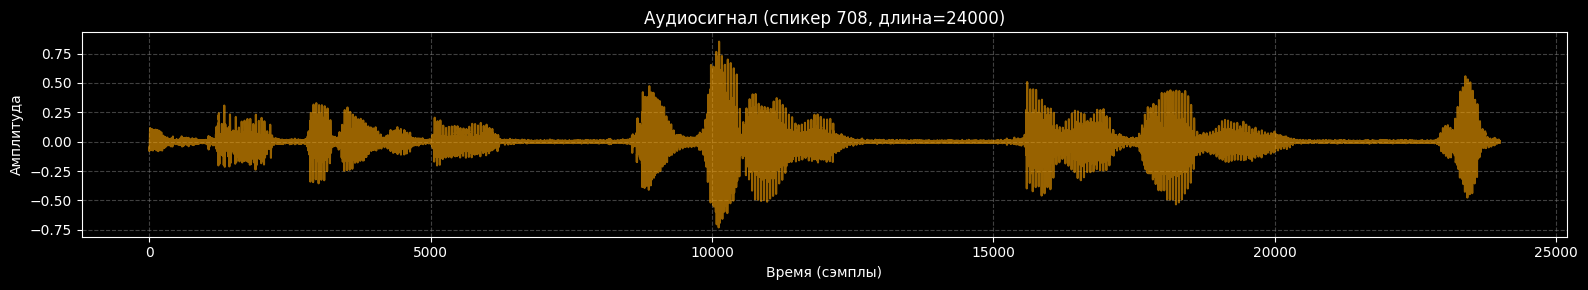

In [11]:
iterator = iter(train_dataset)

# Извлекаем один батч
audio_batch, label_batch = next(iterator)

print("Форма аудио батча:", audio_batch.shape)      # [batch_size, time]
print("Форма меток батча:", label_batch.shape)     # [batch_size]
print("Тип аудио:", audio_batch.dtype)
print("Тип меток:", label_batch.dtype)

print("\nПример меток (первые 20):", label_batch[:20].numpy())
print("Уникальные метки в батче:", np.unique(label_batch.numpy()))
import numpy as np

audio_np = audio_batch.numpy()

print("\nСтатистика аудио в батче:")
print(f"  Минимум: {audio_np.min():.6f}")
print(f"  Максимум: {audio_np.max():.6f}")
print(f"  Среднее:  {audio_np.mean():.6f}")
print(f"  Std:      {audio_np.std():.6f}")

# Проверка на NaN / Inf
print(f"  Есть NaN: {np.isnan(audio_np).any()}")
print(f"  Есть Inf: {np.isinf(audio_np).any()}")


import matplotlib.pyplot as plt

# Возьмём первый пример из батча
sample_audio = audio_np[0]
sample_label = label_batch[0].numpy()

plt.figure(figsize=(16, 3))
plt.plot(sample_audio, color='orange', alpha=0.6)

# Настройка стиля: чёрный фон
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')

# Цвет осей и меток — светлый для контраста
plt.tick_params(colors='white')
plt.gca().spines['top'].set_color('white')
plt.gca().spines['bottom'].set_color('white')
plt.gca().spines['left'].set_color('white')
plt.gca().spines['right'].set_color('white')

plt.title(f"Аудиосигнал (спикер {sample_label}, длина={len(sample_audio)})", color='white')
plt.xlabel("Время (сэмплы)", color='white')
plt.ylabel("Амплитуда", color='white')
plt.grid(True, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

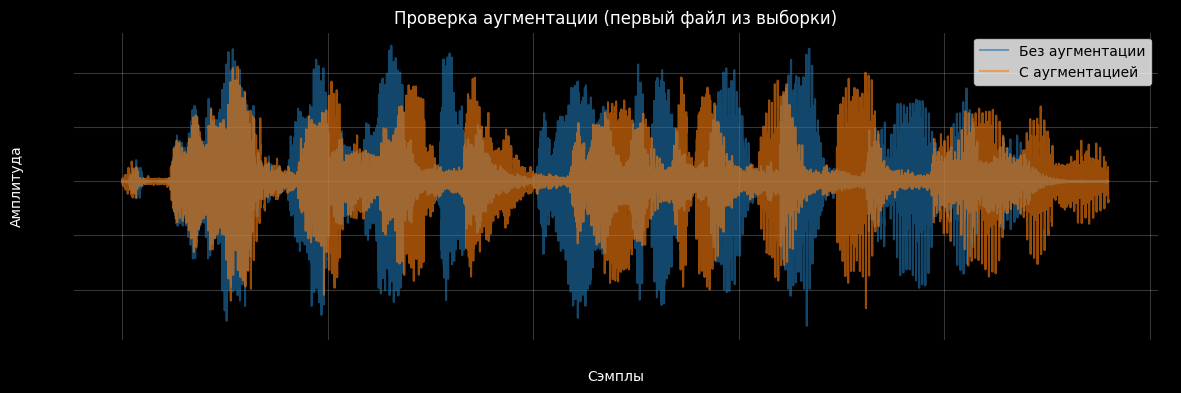

In [ ]:
# Берём первые 5 файлов и соответствующие метки
sample_files = train_files[:5]
sample_labels = train_labels[:5]

# Создаём два стандартных датасета (НЕ balanced!)
test_no_aug = create_standard_dataset(
    file_paths=sample_files,
    labels=sample_labels,
    batch_size=1,
    augment=False,
    # shuffle=False
)

test_with_aug = create_standard_dataset(
    file_paths=sample_files,
    labels=sample_labels,
    batch_size=1,
    augment=True,
    # shuffle=False
)

# Извлекаем один и тот же пример (первый файл)
audio_no_aug, _ = next(iter(test_no_aug))
audio_with_aug, _ = next(iter(test_with_aug))

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 4))
# Настройка стиля: чёрный фон
plt.gca().set_facecolor('black')
plt.gcf().set_facecolor('black')
plt.plot(audio_no_aug[0].numpy(), label='Без аугментации', alpha=0.6, )
plt.plot(audio_with_aug[0].numpy(), label='С аугментацией', alpha=0.6, )
plt.legend()
plt.title("Проверка аугментации (первый файл из выборки)", color='white')
plt.xlabel("Сэмплы", color='white')
plt.ylabel("Амплитуда", color='white')
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

def compute_eer_from_dataset(model, dataset, max_speakers=50, max_samples_per_speaker=10, num_pairs=5000):
    """
    Вычисляет EER на подвыборке датасета.
    """
    # Извлечение эмбеддингов
    embeddings = []
    labels = []
    speaker_counts = {}
    
    for audio_batch, label_batch in dataset:
        emb_batch = model(audio_batch, training=False).numpy()
        labels_batch = label_batch.numpy()
        for emb, lbl in zip(emb_batch, labels_batch):
            if lbl not in speaker_counts:
                if len(speaker_counts) >= max_speakers:
                    continue
                speaker_counts[lbl] = 0
            if speaker_counts[lbl] < max_samples_per_speaker:
                embeddings.append(emb)
                labels.append(lbl)
                speaker_counts[lbl] += 1

    if len(embeddings) < 2:
        return float('nan')
    
    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Генерация пар
    indices = np.arange(len(labels))
    similarities = []
    true_labels = []

    for _ in range(num_pairs):
        i, j = np.random.choice(indices, size=2, replace=False)
        sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0, 0]
        similarities.append(sim)
        true_labels.append(1 if labels[i] == labels[j] else 0)

    similarities = np.array(similarities)
    true_labels = np.array(true_labels)

    # Вычисление EER
    try:
        fpr, tpr, thresholds = roc_curve(true_labels, similarities, pos_label=1)
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
        return float(eer)
    except:
        return float('nan')
    

In [14]:


def analyze_cosine_similarity(model, dataset, max_speakers=50, max_samples_per_speaker=10):
    embeddings = []
    labels = []

    speaker_counts = {}
    for audio_batch, label_batch in dataset:
        emb_batch = model(audio_batch, training=False).numpy()
        labels_batch = label_batch.numpy()

        for emb, lbl in zip(emb_batch, labels_batch):
            if lbl not in speaker_counts:
                if len(speaker_counts) >= max_speakers:
                    continue
                speaker_counts[lbl] = 0
            if speaker_counts[lbl] < max_samples_per_speaker:
                embeddings.append(emb)
                labels.append(lbl)
                speaker_counts[lbl] += 1

    if len(embeddings) < 2:
        return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    from sklearn.metrics.pairwise import cosine_similarity
    sims = cosine_similarity(embeddings)

    intra_sims = []
    inter_sims = []

    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            sim = sims[i, j]
            if labels[i] == labels[j]:
                intra_sims.append(sim)
            else:
                inter_sims.append(sim)

    if not intra_sims or not inter_sims:
        return (np.nan, np.nan, np.nan, np.nan)

    intra_mean = np.mean(intra_sims)
    intra_std = np.std(intra_sims)
    intra_var = np.var(intra_sims)

    inter_mean = np.mean(inter_sims)
    inter_std = np.std(inter_sims)
    inter_var = np.var(inter_sims)

    return intra_mean, intra_std, inter_mean, inter_std

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

EPOCHS = 40
LOG_EVERY_N_STEPS = 10
PATIENCE = 7

EMBEDDING_DIM = 256
# Создаём ОБЕ модели из одного графа
embedder_model, training_model = SpeakerEmbedder(
    embedding_dim=EMBEDDING_DIM,
    n_fft=256,
    sample_rate=8000,
    win_length=200,      # ~25 мс при 8 кГц
    hop_length=50,        
    n_mels=64,
    f_min=100,
    f_max=3600,
)

# Создаём ArcFace слой
# arcface_layer = ArcFaceLayer(
#     num_classes=num_train_speakers,
#     embedding_dim=EMBEDDING_DIM,
#     margin=0.3,
#     scale=64.0
# )


arcface_layer = SubCenterArcFaceLayer(
    num_classes=num_train_speakers,
    embedding_dim=EMBEDDING_DIM,
    K=2,          # ← ключевой параметр(количество центроидов)
    margin=0.2,
    scale=64.0
)



# Оптимизатор
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,  
    decay_steps=STEPS_PER_EPOCH * EPOCHS,
    alpha=1e-5
)

optimizer = Adam(learning_rate=lr_schedule)

# Метрика
train_loss = tf.keras.metrics.Mean(name='train_loss')
val_loss = tf.keras.metrics.Mean(name='val_loss')

@tf.function
def train_step(audio_batch, label_batch):
    with tf.GradientTape() as tape:
        embeddings = training_model(audio_batch, training=True)
        loss = arcface_layer(embeddings, label_batch)
        if tf.math.is_nan(loss):
            tf.print("⚠️ NaN loss detected!")
            tf.print("Embeddings min/max:", tf.reduce_min(embeddings), tf.reduce_max(embeddings))
            tf.print("Labels:", label_batch)
    gradients = tape.gradient(loss, training_model.trainable_variables + arcface_layer.trainable_variables)
    gradients = [tf.clip_by_norm(g, 5.0) if g is not None else g for g in gradients]  # clip_norm = 5.0
    # Проверка градиентов
    grad_norms = [tf.norm(g) for g in gradients if g is not None]
    mean_grad_norm = tf.reduce_mean(grad_norms)
    if tf.math.is_nan(mean_grad_norm):
        tf.print("Средняя норма градиентов:", mean_grad_norm)


    optimizer.apply_gradients(zip(gradients, training_model.trainable_variables + arcface_layer.trainable_variables))
    train_loss.update_state(loss)





In [ ]:
# del training_model, embedder_model

In [ ]:
import numpy as np
import time
import tensorflow as tf
import matplotlib.pyplot as plt

# Параметры стабилизации EER
EER_SMOOTH_WINDOW = 3
best_smoothed_eer = float('inf')
patience_counter = 0

# Включить анализ косинусной схожести?
ENABLE_SIMILARITY_ANALYSIS = True  # ← можно отключить при отладке или для скорости

# История для анализа
history = {
    'epoch_train_loss': [],
    'epoch_val_loss': [],
    'epoch_val_eer_raw': [],
    'epoch_val_eer_smoothed': [],
    'epoch_val_intra_sim': [],   # ← новое
    'epoch_val_inter_sim': [],   # ← новое
    'epoch_val_separation': [],
}

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*60}")
    
    train_loss.reset_states()
    val_loss.reset_states()
    epoch_start = time.time()

    # === Обучение ===
    train_iter = iter(train_dataset)
    for step in range(STEPS_PER_EPOCH):
        try:
            audio_batch, label_batch = next(train_iter)
        except StopIteration:
            print("⚠️ Датасет закончился раньше времени!")
            break

        train_step(audio_batch, label_batch)
        if (step + 1) % LOG_EVERY_N_STEPS == 0:
            print(f"  Train Step {step + 1}: Loss = {train_loss.result().numpy():.4f}")

    train_time = time.time() - epoch_start

    # === Вычисление EER на валидации ===
    print("  Вычисление EER на валидации...")
    val_eer_raw = compute_eer_from_dataset(
        embedder_model,
        val_dataset,
        max_speakers=50,
        max_samples_per_speaker=30,
        num_pairs=10000
    )

    # === Анализ косинусной схожести ===
    val_intra_sim = np.nan
    val_inter_sim = np.nan
    separation = np.nan
    if ENABLE_SIMILARITY_ANALYSIS:
        try:
            val_intra_sim, intra_std, val_inter_sim, inter_std = analyze_cosine_similarity(
                embedder_model,
                val_dataset,
                max_speakers=50,
                max_samples_per_speaker=30
            )

            print(f"  Val Intra-sim: {val_intra_sim:.4f} ± {intra_std:.4f}")
            print(f"  Val Inter-sim: {val_inter_sim:.4f} ± {inter_std:.4f}")
            separation = val_intra_sim - val_inter_sim
            print(f"  Cosine separation (intra - inter): {separation:.4f}")
        except Exception as e:
            print(f"  ❌ Ошибка при анализе схожести: {e}")
            val_intra_sim = np.nan
            val_inter_sim = np.nan



    # === Обновление истории ===
    current_train_loss = float(train_loss.result().numpy())
    current_val_loss = float(val_loss.result().numpy())  # если вы всё же используете val_loss

    history['epoch_train_loss'].append(current_train_loss)
    history['epoch_val_loss'].append(current_val_loss)
    history['epoch_val_eer_raw'].append(val_eer_raw)
    history['epoch_val_intra_sim'].append(val_intra_sim)
    history['epoch_val_inter_sim'].append(val_inter_sim)
    history['epoch_val_separation'].append(separation)

    # === Сглаживание EER ===
    recent_eers = history['epoch_val_eer_raw'][-EER_SMOOTH_WINDOW:]
    smoothed_eer = np.mean([e for e in recent_eers if not np.isnan(e)] or [np.nan])
    history['epoch_val_eer_smoothed'].append(smoothed_eer)

    # === Логирование ===
    print(f"\nEpoch {epoch + 1} Summary:")
    print(f"  Train Loss: {current_train_loss:.6f} (time: {train_time:.1f}s)")
    print(f"  Val   EER (raw)     : {val_eer_raw:.4f}" if not np.isnan(val_eer_raw) else "  Val   EER (raw)     : NaN")
    print(f"  Val   EER (smoothed): {smoothed_eer:.4f}" if not np.isnan(smoothed_eer) else "  Val   EER (smoothed): NaN")
    
    if ENABLE_SIMILARITY_ANALYSIS:
        print(f"  Val   Intra-sim     : {val_intra_sim:.4f}" if not np.isnan(val_intra_sim) else "  Val   Intra-sim     : NaN")
        print(f"  Val   Inter-sim     : {val_inter_sim:.4f}" if not np.isnan(val_inter_sim) else "  Val   Inter-sim     : NaN")
        if not (np.isnan(val_intra_sim) or np.isnan(val_inter_sim)):
            print(f"  Val   Separation    : {val_intra_sim - val_inter_sim:.4f}")

    # === Сохранение по сглаженному EER ===
    if not np.isnan(smoothed_eer):
        if smoothed_eer < best_smoothed_eer:
            best_smoothed_eer = smoothed_eer
            patience_counter = 0
            embedder_model.save_weights(
                rf'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/new_best_embedder_by_eer_epoh_4.{epoch + 1}.h5'
            )
            print("✅ Model saved (best smoothed EER so far)")
        else:
            patience_counter += 1
            print(f"⚠️  No improvement in smoothed EER for {patience_counter} epoch(s)")
    else:
        patience_counter += 1
        print("⚠️  EER is NaN — skipping save")

    # === Early stopping ===
    if patience_counter >= PATIENCE:
        print(f"\n🛑 Early stopping triggered after {epoch + 1} epochs")
        break


Epoch 1/40
  Train Step 10: Loss = 27.5468
  Train Step 20: Loss = 27.1696
  Train Step 30: Loss = 27.2031
  Train Step 40: Loss = 26.9708
  Train Step 50: Loss = 26.7531
  Train Step 60: Loss = 26.5695
  Train Step 70: Loss = 26.3198
  Train Step 80: Loss = 26.0215
  Train Step 90: Loss = 25.7443
  Train Step 100: Loss = 25.5120
  Train Step 110: Loss = 25.3522
  Train Step 120: Loss = 25.1264
  Train Step 130: Loss = 24.9284
  Train Step 140: Loss = 24.7536
  Train Step 150: Loss = 24.5858
  Train Step 160: Loss = 24.3996
  Train Step 170: Loss = 24.2544
  Train Step 180: Loss = 24.0949
  Train Step 190: Loss = 23.9421
  Train Step 200: Loss = 23.8323
  Train Step 210: Loss = 23.7004
  Train Step 220: Loss = 23.5976
  Train Step 230: Loss = 23.4805
  Train Step 240: Loss = 23.3863
  Train Step 250: Loss = 23.2876
  Train Step 260: Loss = 23.1900
  Train Step 270: Loss = 23.1106
  Train Step 280: Loss = 23.0315
  Train Step 290: Loss = 22.9591
  Train Step 300: Loss = 22.8760
  Train

In [130]:
embedder_model.save_weights(
                rf'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/new_best_embedder_by_eer_epoh_4.22.final.h5'
            )

#### Просмотр mel спектрограмм

In [334]:
embedder_model, training_model = SpeakerEmbedder(
    embedding_dim=EMBEDDING_DIM,
    n_fft=256,
    sample_rate=8000,
    win_length=200,      # ~25 мс при 8 кГц
    hop_length=50,        
    n_mels=80,
    f_min=100,
    f_max=3800,
    )

model_mel = Model(embedder_model.layers[0].input, embedder_model.layers[1].output)
mel_out = model_mel(audio_batch)

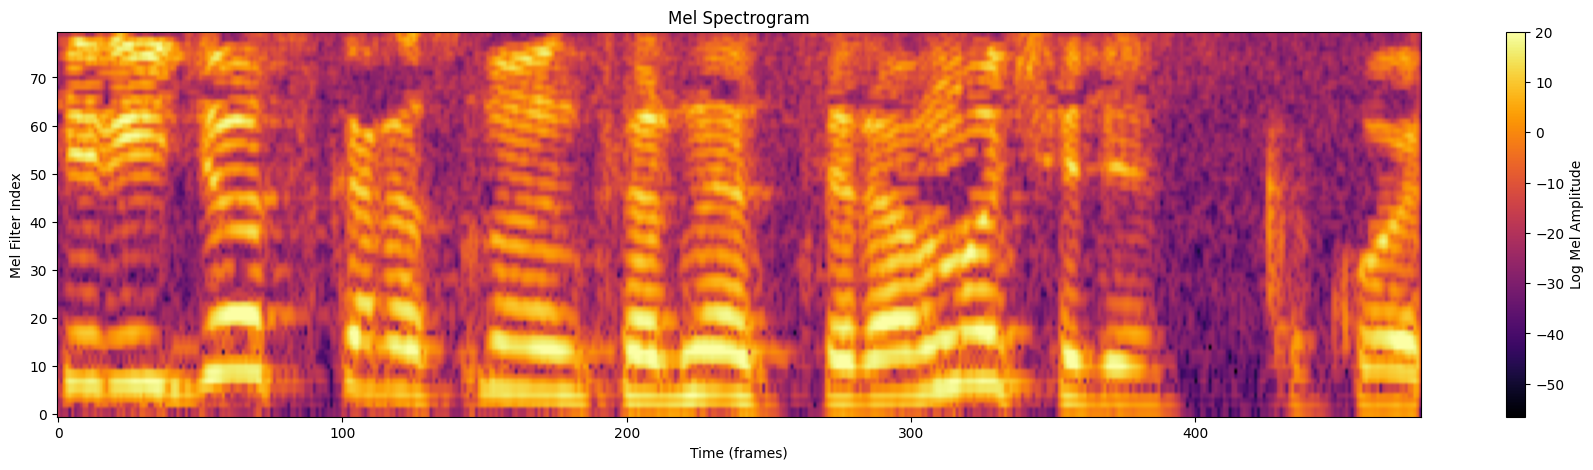

In [336]:
plt.figure(figsize=(22, 5))
img = plt.imshow(mel_out[2, :, :, 0].numpy(), aspect='auto', origin='lower', cmap='inferno')
plt.colorbar(img, label='Log Mel Amplitude')
plt.title("Mel Spectrogram")
plt.xlabel("Time (frames)")
plt.ylabel("Mel Filter Index")
plt.show()

In [ ]:
# Анализ датасета
print("📊 Dataset Analysis:")
print(f"Total samples: {len(file_paths)}")
print(f"Total classes: {num_classes}")
print(f"Average samples per class: {len(file_paths) / num_classes:.1f}")

# Проверка баланса классов
from collections import Counter
label_counts = Counter(labels)
print(f"Min samples per class: {min(label_counts.values())}")
print(f"Max samples per class: {max(label_counts.values())}")

# Проверка длительности аудио
def analyze_audio_durations(file_paths, sample_rate=8000):
    durations = []
    for i, file_path in enumerate(file_paths[:100]):  # проверяем 100 файлов
        try:
            audio_binary = tf.io.read_file(file_path)
            audio, _ = tf.audio.decode_wav(audio_binary)
            duration = audio.shape[0] / sample_rate
            durations.append(duration)
        except:
            continue
    
    print(f"Audio durations - Min: {min(durations):.2f}s, Max: {max(durations):.2f}s, Avg: {np.mean(durations):.2f}s")
    return durations

durations = analyze_audio_durations(file_paths)

In [24]:
# embedder_model.load_weights(r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/best_embedder_by_eer.h5')
# embedder_model.load_weights(r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/best_embedder_by_eer_epoh_16.h5')

# embedder_model.load_weights(r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/best_embedder_by_eer_epoh_2.final.h5')

embedder_model.load_weights(r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/new_best_embedder_by_eer_epoh_4.14.h5')

In [28]:
# embedding_model = tf.keras.models.load_model(r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/new_best_embedder_by_eer_epoh_3.16.final.h5')
embedder_model.load_weights(r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/new_best_embedder_by_eer_epoh_3.15.h5')

График по эпохам (стандартный)

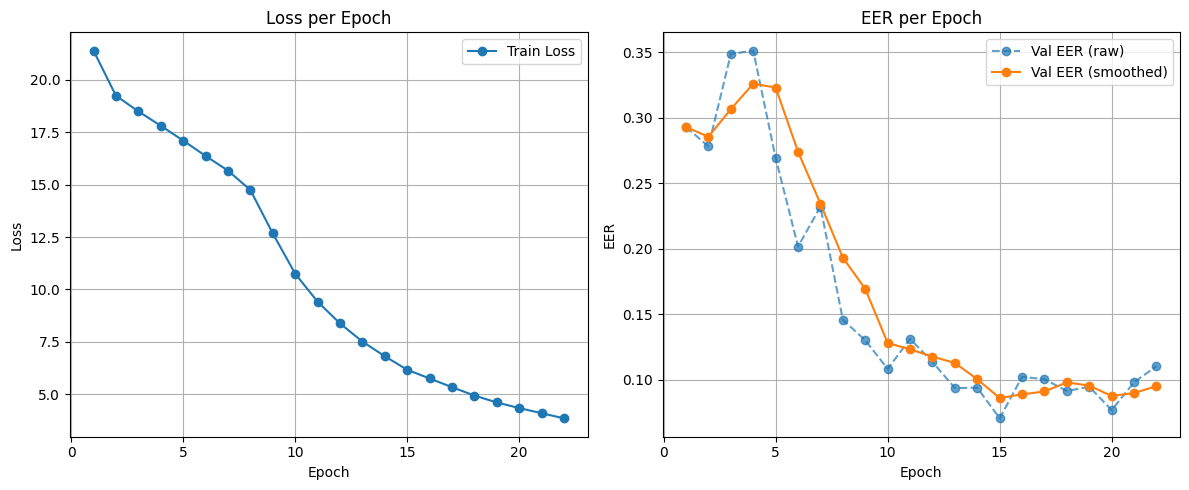

In [126]:
import matplotlib.pyplot as plt

epochs = range(1, len(history['epoch_train_loss']) + 1)

plt.figure(figsize=(12, 5))

# --- Loss ---
plt.subplot(1, 2, 1)
plt.plot(epochs, history['epoch_train_loss'], label='Train Loss', marker='o')
# plt.plot(epochs, history['epoch_val_loss'], label='Val Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- EER ---
plt.subplot(1, 2, 2)
plt.plot(epochs, history['epoch_val_eer_raw'], label='Val EER (raw)', marker='o', linestyle='--', alpha=0.7)
plt.plot(epochs, history['epoch_val_eer_smoothed'], label='Val EER (smoothed)', marker='o')
plt.title('EER per Epoch')
plt.xlabel('Epoch')
plt.ylabel('EER')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

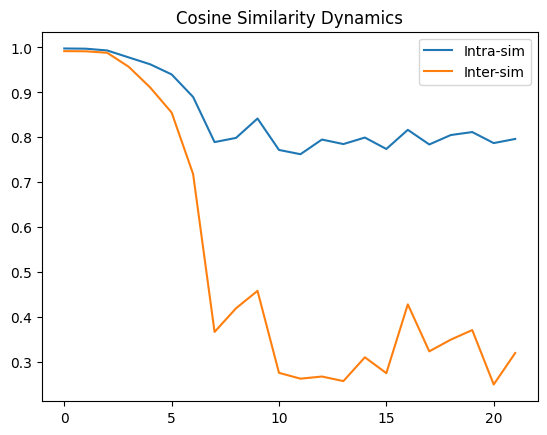

In [127]:
plt.plot(history['epoch_val_intra_sim'], label='Intra-sim')
plt.plot(history['epoch_val_inter_sim'], label='Inter-sim')
plt.legend()
plt.title('Cosine Similarity Dynamics')
plt.show()

In [ ]:
embedder_model.load_weights(r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/best_embedder_by_eer_epoh_2.final.h5')

Оценка качества на тестовом наборе

Интерпретация EER: 

EER < 0.05 (5%) — отличный результат для 8 кГц и 300 спикеров.<br>
EER 0.05–0.10 — хороший.<br>
EER > 0.15 — модель слабая, нужно улучшать.<br>

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve

def compute_embeddings(model, dataset):
    """Извлекает эмбеддинги и метки из датасета."""
    embeddings = []
    labels = []
    for audio_batch, label_batch in dataset:
        emb_batch = model(audio_batch, training=False)  # [B, D]
        embeddings.append(emb_batch.numpy())
        labels.append(label_batch.numpy())
    return np.vstack(embeddings), np.concatenate(labels)

def generate_pairs(embeddings, labels, num_pairs=10000):
    """Генерирует случайные positive/negative пары."""
    indices = np.arange(len(labels))
    pairs = []
    labels_pair = []

    for _ in range(num_pairs):
        i, j = np.random.choice(indices, size=2, replace=False)
        sim = cosine_similarity([embeddings[i]], [embeddings[j]])[0, 0]
        pairs.append(sim)
        labels_pair.append(1 if labels[i] == labels[j] else 0)

    return np.array(pairs), np.array(labels_pair)

def compute_eer(y_true, y_scores):
    """Вычисляет EER по бинарным меткам и схожестям."""
    fpr, tpr, thresholds = roc_curve(y_true, y_scores, pos_label=1)
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    thresh = interp1d(fpr, thresholds)(eer)
    return eer, thresh

# === Использование ===
print("Извлечение эмбеддингов на тестовом наборе...")
test_embeddings, test_labels = compute_embeddings(embedder_model, test_dataset)

print("Генерация пар...")
y_scores, y_true = generate_pairs(test_embeddings, test_labels, num_pairs=20000)

print("Вычисление EER...")
eer, threshold = compute_eer(y_true, y_scores)
print(f"🎯 EER: {eer:.4f} (threshold: {threshold:.4f})")

Извлечение эмбеддингов на тестовом наборе...
Генерация пар...
Вычисление EER...
🎯 EER: 0.0755 (threshold: 0.6297)


## Визуализация

#### визуализации t-SNE

Интерпретация результата

✅ Хорошо: каждый спикер — отдельный плотный кластер, кластеры далеко друг от друга.

❌ Плохо: кластеры пересекаются, точки одного спикера разбросаны по всему пространству.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns

def visualize_embeddings_tsne(model, dataset, class_names, max_speakers=50, max_samples_per_speaker=20, random_state=42):
    """
    Визуализирует эмбеддинги спикеров с помощью t-SNE.
    
    Args:
        model: обученная модель embedder_model (возвращает L2-нормализованные эмбеддинги)
        dataset: tf.data.Dataset с аудио и метками
        class_names: список имён/ID спикеров (для легенды)
        max_speakers: сколько спикеров отобразить (для читаемости)
        max_samples_per_speaker: макс. число записей на спикера
        random_state: для воспроизводимости
    """
    print("Извлечение эмбеддингов для визуализации...")
    embeddings = []
    labels = []

    # Ограничим число спикеров
    speaker_counts = {}
    for audio_batch, label_batch in dataset:
        emb_batch = model(audio_batch, training=False).numpy()
        labels_batch = label_batch.numpy()

        for emb, lbl in zip(emb_batch, labels_batch):
            if lbl not in speaker_counts:
                if len(speaker_counts) >= max_speakers:
                    continue  # пропускаем лишних спикеров
                speaker_counts[lbl] = 0

            if speaker_counts[lbl] < max_samples_per_speaker:
                embeddings.append(emb)
                labels.append(lbl)
                speaker_counts[lbl] += 1

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    print(f"Всего эмбеддингов: {len(embeddings)} от {len(speaker_counts)} спикеров")

    # t-SNE
    print("Запуск t-SNE...")
    tsne = TSNE(
        n_components=2,
        perplexity=30,
        # n_iter=1000,
        max_iter=1000,
        random_state=random_state,
        metric='cosine'  # важно для нормализованных эмбеддингов!
    )
    embeddings_2d = tsne.fit_transform(embeddings)

    # Визуализация
    plt.figure(figsize=(18, 10))
    unique_labels = np.unique(labels)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', 'P', '*', 'h', 'H', '+', 'x', 'X', 'd', '|', '_']

    for i, lbl in enumerate(unique_labels):
        idx = labels == lbl
        marker = markers[i % len(markers)]
        plt.scatter(
            embeddings_2d[idx, 0],
            embeddings_2d[idx, 1],
            color=colors[i % len(colors)],
            label=class_names[lbl] if lbl < len(class_names) else f"Speaker {lbl}",
            alpha=0.7,
            marker=marker,
            s=50
        )

    plt.title("t-SNE визуализация спикер-эмбеддингов", fontsize=16)
    plt.xlabel("t-SNE компонента 1")
    plt.ylabel("t-SNE компонента 2")
    
    # Легенда только если спикеров не слишком много
    if len(unique_labels) <= 20:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        plt.text(0.02, 0.98, f"Отображено {len(unique_labels)} спикеров", 
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.savefig("speaker_embeddings_tsne.png", dpi=250, bbox_inches='tight')
    plt.show()

Извлечение эмбеддингов для визуализации...
Всего эмбеддингов: 1823 от 51 спикеров
Запуск t-SNE...


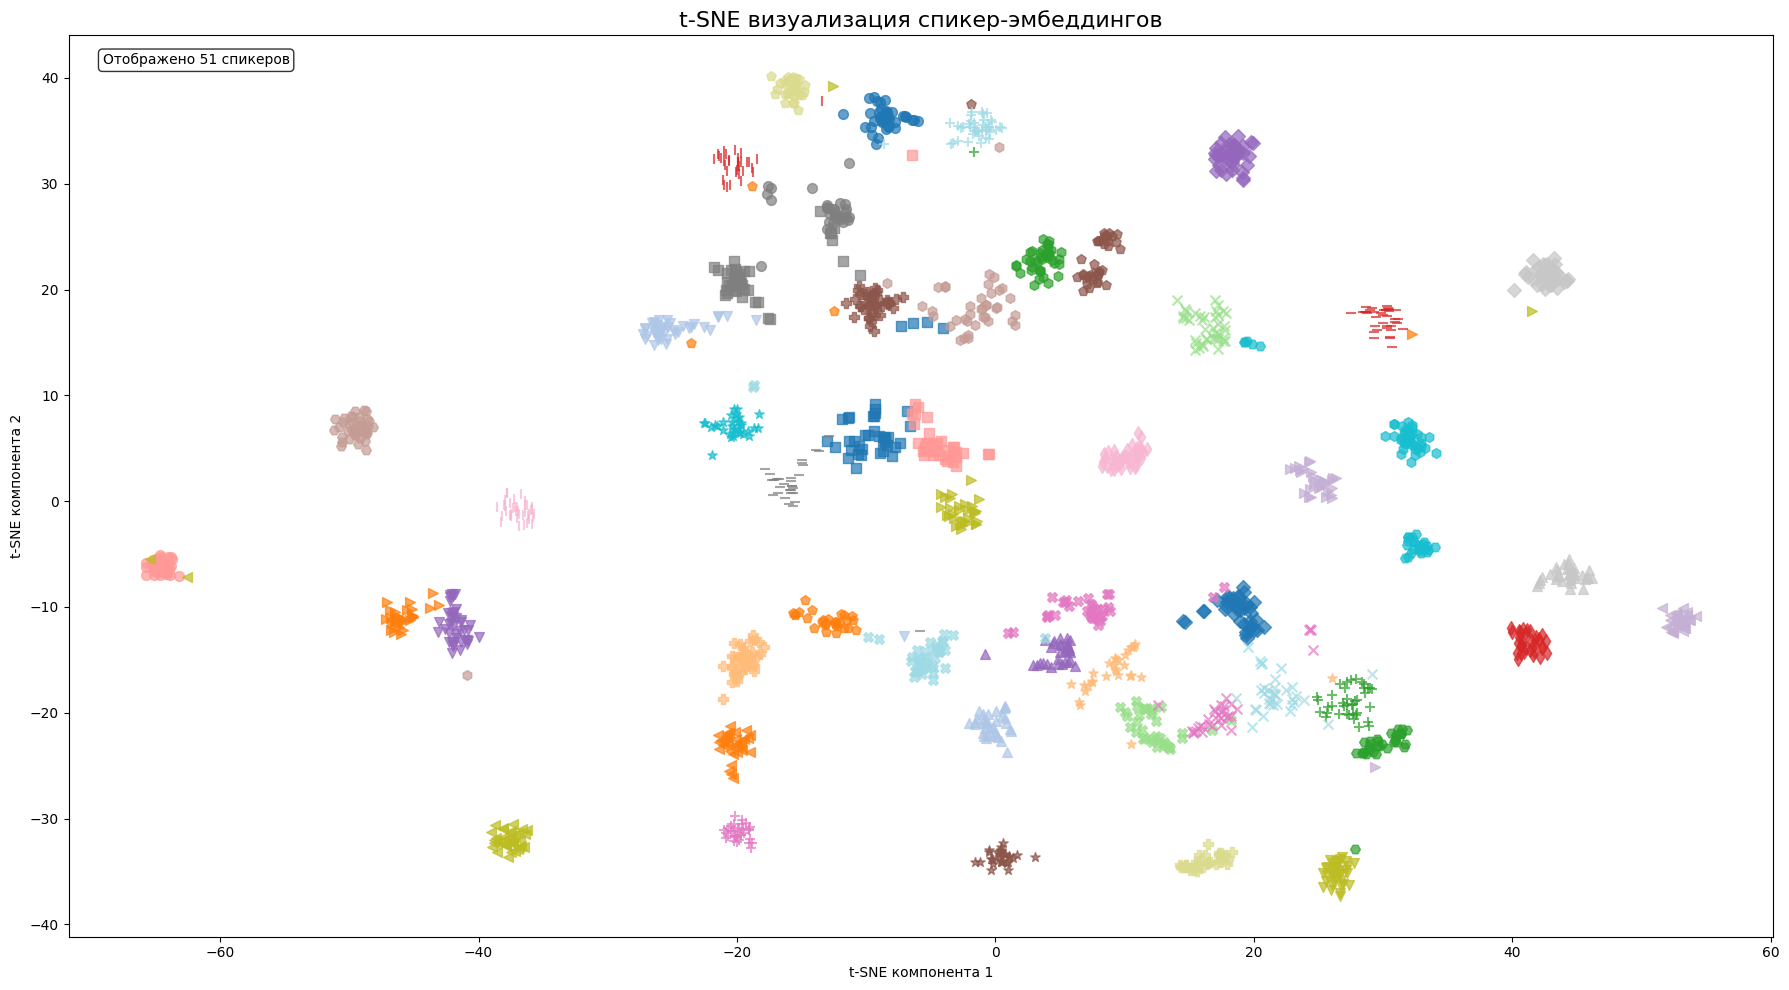

In [26]:
# Визуализация на валидационном наборе (или test_dataset)
visualize_embeddings_tsne(
    model=embedder_model,
    dataset=test_dataset,  # или test_dataset
    class_names=class_names,
    max_speakers=60,      # покажем 30 спикеров
    max_samples_per_speaker=40
)

In [27]:
# train_speakers = set(train_labels)
# val_speakers = set(val_labels)
# assert len(train_speakers & val_speakers) == 0, "УТЕЧКА СПИКЕРОВ!"

def analyze_cosine_similarity(model, dataset, max_speakers=50, max_samples_per_speaker=10):
    """
    Вычисляет среднюю косинусную схожесть внутри спикера и между спикерами.
    """
    embeddings = []
    labels = []

    speaker_counts = {}
    for audio_batch, label_batch in dataset:
        emb_batch = model(audio_batch, training=False).numpy()
        labels_batch = label_batch.numpy()

        for emb, lbl in zip(emb_batch, labels_batch):
            if lbl not in speaker_counts:
                if len(speaker_counts) >= max_speakers:
                    continue
                speaker_counts[lbl] = 0

            if speaker_counts[lbl] < max_samples_per_speaker:
                embeddings.append(emb)
                labels.append(lbl)
                speaker_counts[lbl] += 1

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Косинусная схожесть
    from sklearn.metrics.pairwise import cosine_similarity
    sims = cosine_similarity(embeddings)

    # Внутри-спикерные пары
    intra_sims = []
    inter_sims = []

    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            sim = sims[i, j]
            if labels[i] == labels[j]:
                intra_sims.append(sim)
            else:
                inter_sims.append(sim)

    print(f"  Внутри-спикерная схожесть (mean ± std): {np.mean(intra_sims):.4f} ± {np.std(intra_sims):.4f}")
    print(f"  Между-спикерная схожесть (mean ± std): {np.mean(inter_sims):.4f} ± {np.std(inter_sims):.4f}")

    return np.mean(intra_sims), np.mean(inter_sims)

In [28]:
intra_mean, inter_mean = analyze_cosine_similarity(embedder_model, val_dataset, max_speakers=50, max_samples_per_speaker=20)
print(f"Разделение: {intra_mean - inter_mean:.4f}")

  Внутри-спикерная схожесть (mean ± std): 0.7903 ± 0.1506
  Между-спикерная схожесть (mean ± std): 0.2641 ± 0.2435
Разделение: 0.5262


косинусная схожести эмбеддингов

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_cosine_histograms_from_dataset(model, dataset, max_speakers=50, max_samples_per_speaker=10, bins=50, figsize=(10, 6)):
    """
    Строит гистограммы косинусной схожести эмбеддингов:
    - зелёная: внутри одного спикера
    - красная: между разными спикерами
    
    Args:
        model: модель, возвращающая эмбеддинги (не логиты ArcFace!)
        dataset: tf.data.Dataset с парами (аудио, метка)
        max_speakers: макс. число спикеров для анализа
        max_samples_per_speaker: макс. образцов на спикера
        bins: количество бинов гистограммы
        figsize: размер графика
    """
    # Сбор эмбеддингов и меток (точно как в вашей функции)
    embeddings = []
    labels = []

    speaker_counts = {}
    for audio_batch, label_batch in dataset:
        emb_batch = model(audio_batch, training=False).numpy()
        labels_batch = label_batch.numpy()

        for emb, lbl in zip(emb_batch, labels_batch):
            if lbl not in speaker_counts:
                if len(speaker_counts) >= max_speakers:
                    continue
                speaker_counts[lbl] = 0

            if speaker_counts[lbl] < max_samples_per_speaker:
                embeddings.append(emb)
                labels.append(lbl)
                speaker_counts[lbl] += 1

    embeddings = np.array(embeddings)
    labels = np.array(labels)

    # Косинусная схожесть
    sims = cosine_similarity(embeddings)

    # Разделение на intra и inter
    intra_sims = []
    inter_sims = []

    n = len(labels)
    for i in range(n):
        for j in range(i + 1, n):
            sim = sims[i, j]
            if labels[i] == labels[j]:
                intra_sims.append(sim)
            else:
                inter_sims.append(sim)

    # Вывод статистики (опционально, но полезно)
    intra_mean = np.mean(intra_sims) if intra_sims else 0.0
    inter_mean = np.mean(inter_sims) if inter_sims else 0.0
    print(f"Внутри-спикерная схожесть: {intra_mean:.4f} ± {np.std(intra_sims):.4f}")
    print(f"Между-спикерная схожесть: {inter_mean:.4f} ± {np.std(inter_sims):.4f}")
    print(f"Разделение: {intra_mean - inter_mean:.4f}")

    # Построение гистограмм
    plt.figure(figsize=figsize)
    plt.hist(intra_sims, bins=bins, alpha=0.7, density=True, 
             label=f'Внутри-спикерная (n={len(intra_sims)})', color='green')
    plt.hist(inter_sims, bins=bins, alpha=0.7, density=True, 
             label=f'Между-спикерная (n={len(inter_sims)})', color='red')
    
    plt.xlabel('Косинусная схожесть')
    plt.ylabel('Плотность')
    plt.title('Распределение косинусной схожести эмбеддингов')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0.0, 1.0)
    plt.tight_layout()
    plt.show()

Внутри-спикерная схожесть: 0.8079 ± 0.1160
Между-спикерная схожесть: 0.2952 ± 0.2408


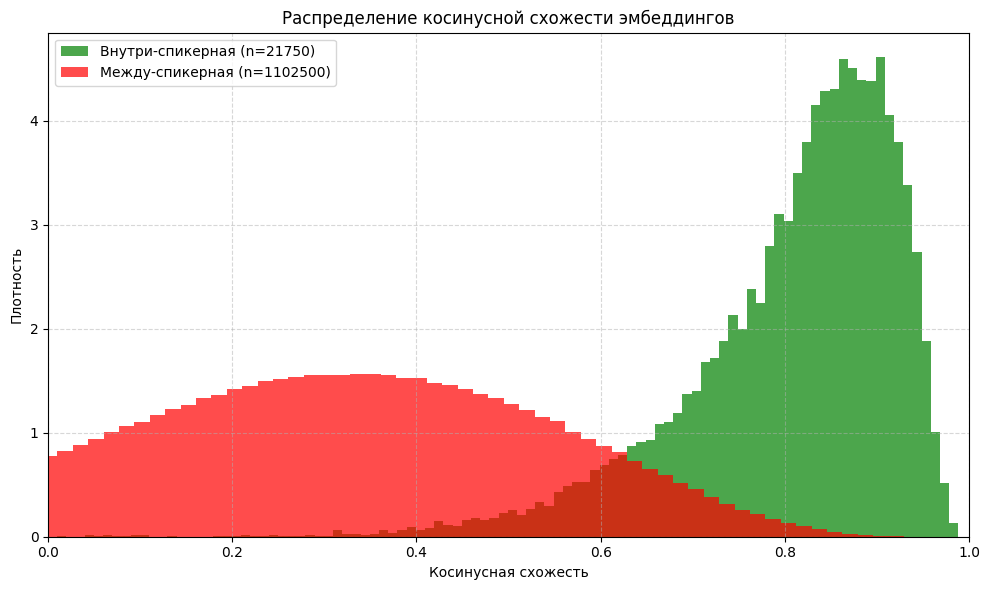

In [30]:
# model_emb — ваша модель, возвращающая эмбеддинги (не ArcFace logits!)
plot_cosine_histograms_from_dataset(
    model=embedder_model,
    dataset=test_dataset,
    max_speakers=50,
    max_samples_per_speaker=30,
    bins=100
)

#### Тест на записях

In [34]:
import tensorflow as tf
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


📊 Результаты:
ROC-AUC: 0.9708
EER: 0.0661
Оптимальный порог (EER): 0.9643


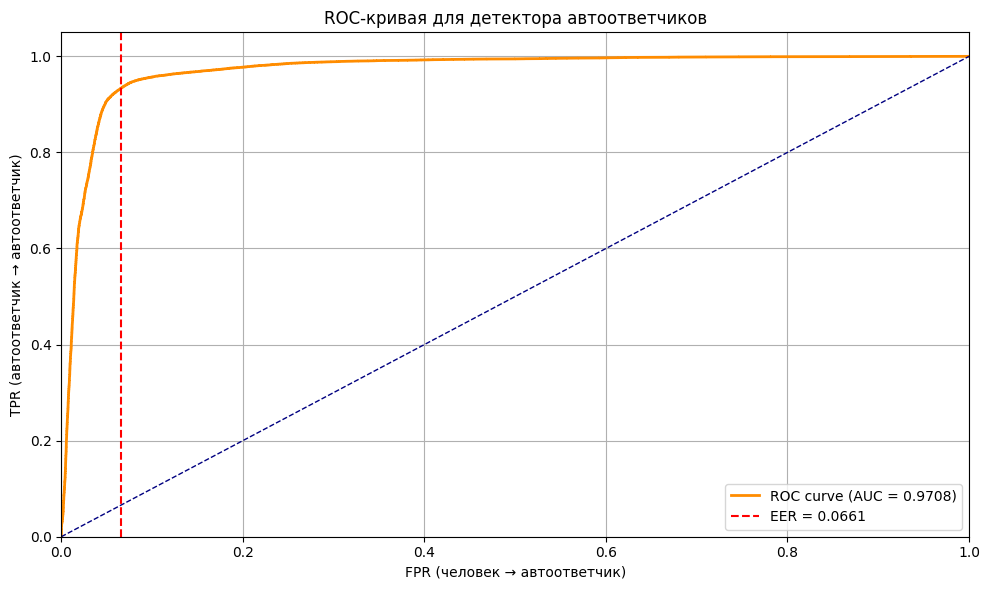


🔍 Матрица ошибок (порог = 0.9643):
TP: 20355  (автоответчик → автоответчик)
FP: 2513  (человек → автоответчик)
TN: 35507  (человек → человек)
FN: 1441  (автоответчик → человек)

📌 Ключевые метрики:
FRR (пропуск автоответчика): 0.0661
FAR (ложное срабатывание на человека): 0.0661


In [ ]:


# --- 1. Загрузка модели ---
# MODEL_WEIGHTS_PATH = r'C:/Users/Home/VSCode/GigaAM_v2/train_smart_detect/train_smart_detect/embedded/best_embedder_by_eer_epoh_2.X.h5'

# _, training_model = SpeakerEmbedder(
#     embedding_dim=256,
#     n_fft=256,
#     sample_rate=8000,
#     win_length=200,
#     hop_length=50,
#     n_mels=64,
#     f_min=100,
#     f_max=3600,
# )
# training_model.load_weights(MODEL_WEIGHTS_PATH)
# embedder_model = training_model  # выход L2-нормализован

# --- 2. Функции загрузки ---
MAX_LENGTH = 8000 * 5

def load_audio_batch(file_paths, max_length=MAX_LENGTH):
    """Загружает батч файлов и возвращает тензор [B, T]"""
    audios = []
    for fp in file_paths:
        audio_binary = tf.io.read_file(fp)
        audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
        audio = tf.squeeze(audio, axis=-1)
        audio = tf.where(tf.math.is_finite(audio), audio, 0.0)
        audio = tf.clip_by_value(audio, -1.0, 1.0)
        
        audio_len = int(audio.shape[0])
        if audio_len > max_length:
            start = np.random.randint(0, audio_len - max_length + 1)
            audio = audio[start:start + max_length]
        else:
            pad_len = max_length - audio_len
            audio = tf.pad(audio, [[0, pad_len]], constant_values=0.0)
        audios.append(audio)
    return tf.stack(audios, axis=0)  # [B, T]

# --- 3. Подготовка данных ---
DATA_DIR = r'E:\python\train_smart_detect\train2'

smart_dir = os.path.join(DATA_DIR, 'smart')
human_dir = os.path.join(DATA_DIR, 'human')

# Получаем все .wav файлы
all_smart_files = [os.path.join(smart_dir, f) for f in os.listdir(smart_dir) if f.lower().endswith('.wav')]
all_human_files = [os.path.join(human_dir, f) for f in os.listdir(human_dir) if f.lower().endswith('.wav')]

# --- Формируем Reference Set: только *_001.wav из 'smart' ---
reference_files = [f for f in all_smart_files if f.endswith('_001.wav')]
print(f"Reference (база): {len(reference_files)} записей (_001.wav)")

# --- Формируем Query Set ---
# Позитивы: все автоответчики НЕ _001
pos_queries = [f for f in all_smart_files if not f.endswith('_001.wav')]
# Негативы: все люди
neg_queries = all_human_files

print(f"Запросы: {len(pos_queries)} автоответчиков (не _001), {len(neg_queries)} людей")

# --- 4. Генерация эмбеддингов батчами ---
BATCH_SIZE = 32

def get_embeddings_batched(file_paths, model, batch_size=BATCH_SIZE):
    embeddings = []
    for i in range(0, len(file_paths), batch_size):
        batch = file_paths[i:i + batch_size]
        audio_batch = load_audio_batch(batch)
        emb_batch = model(audio_batch, training=False).numpy()  # [B, 256]
        embeddings.append(emb_batch)
    return np.vstack(embeddings) if embeddings else np.array([])

# Reference embeddings
print("Генерация эмбеддингов для базы...")
ref_embeddings = get_embeddings_batched(reference_files, embedder_model)
if ref_embeddings.size == 0:
    raise ValueError("Нет файлов *_001.wav в папке smart!")

# Query embeddings
print("Генерация эмбеддингов для запросов...")
all_queries = pos_queries + neg_queries
query_embeddings = get_embeddings_batched(all_queries, embedder_model)
true_labels = np.array([1] * len(pos_queries) + [0] * len(neg_queries))  # 1 = автоответчик, 0 = человек

print(f"Всего запросов: {len(all_queries)}")

# --- 5. Вычисление максимального сходства (батчами для скорости) ---
print("Вычисление максимального сходства с базой...")
# query_embeddings: [Q, 256], ref_embeddings: [R, 256]
# Используем матричное умножение: Q x R
similarities = cosine_similarity(query_embeddings, ref_embeddings)  # [Q, R]
max_similarities = np.max(similarities, axis=1)  # [Q]

# --- 6. Оценка ROC / AUC / EER ---
fpr, tpr, thresholds = roc_curve(true_labels, max_similarities, pos_label=1)
roc_auc = auc(fpr, tpr)

# Equal Error Rate (EER)
eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
eer_threshold = interp1d(fpr, thresholds)(eer)

print(f"\n📊 Результаты:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"EER: {eer:.4f}")
print(f"Оптимальный порог (EER): {eer_threshold:.4f}")

# --- 7. Визуализация ---
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.axvline(x=eer, color='red', linestyle='--', label=f'EER = {eer:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FPR (человек → автоответчик)')
plt.ylabel('TPR (автоответчик → автоответчик)')
plt.title('ROC-кривая для детектора автоответчиков')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Метрики на пороге EER ---
predictions = (max_similarities >= eer_threshold).astype(int)
tp = np.sum((predictions == 1) & (true_labels == 1))
fp = np.sum((predictions == 1) & (true_labels == 0))
tn = np.sum((predictions == 0) & (true_labels == 0))
fn = np.sum((predictions == 0) & (true_labels == 1))

print(f"\n🔍 Матрица ошибок (порог = {eer_threshold:.4f}):")
print(f"TP: {tp}  (автоответчик → автоответчик)")
print(f"FP: {fp}  (человек → автоответчик)")
print(f"TN: {tn}  (человек → человек)")
print(f"FN: {fn}  (автоответчик → человек)")

frr = fn / (tp + fn) if (tp + fn) > 0 else 0  # False Rejection Rate
far = fp / (tn + fp) if (tn + fp) > 0 else 0  # False Acceptance Rate

print(f"\n📌 Ключевые метрики:")
print(f"FRR (пропуск автоответчика): {frr:.4f}")
print(f"FAR (ложное срабатывание на человека): {far:.4f}")

# --- 9. Функция для инференса на одном файле ---
def is_autoanswerer(file_path, ref_embeddings, model, threshold=eer_threshold):
    """
    Определяет, является ли аудио автоответчиком.
    Возвращает: (is_autoanswerer: bool, max_similarity: float)
    """
    audio = load_audio_batch([file_path])
    emb = model(audio, training=False).numpy()[0]  # [256]
    sims = cosine_similarity([emb], ref_embeddings)[0]  # [R]
    max_sim = np.max(sims)
    return max_sim >= threshold, max_sim

# Пример:
# is_aa, sim = is_autoanswerer("test_call.wav", ref_embeddings, embedder_model)
# print(f"Автоответчик? {is_aa} (сходство: {sim:.4f})")

Вычисление сходства с базой эталонов...

Выберите способ выбора порога:
  (1) Задать целевой FPR (например, 0.01 = 1%)
  (2) Задать целевой TPR (например, 0.99 = 99%)
  (3) Использовать EER (FAR = FRR)

✅ Выбран порог по FPR ≤ 0.0100
Выбранный порог сходства: 0.995777
Достигнутый FPR: 0.009968 (1.00%)
Достигнутый TPR: 0.365939 (36.59%)

📌 Итоговые метрики:
FAR (человек → автоответчик): 0.009968
FRR (автоответчик → человек): 0.634061

Порог сохранён в: selected_threshold.txt


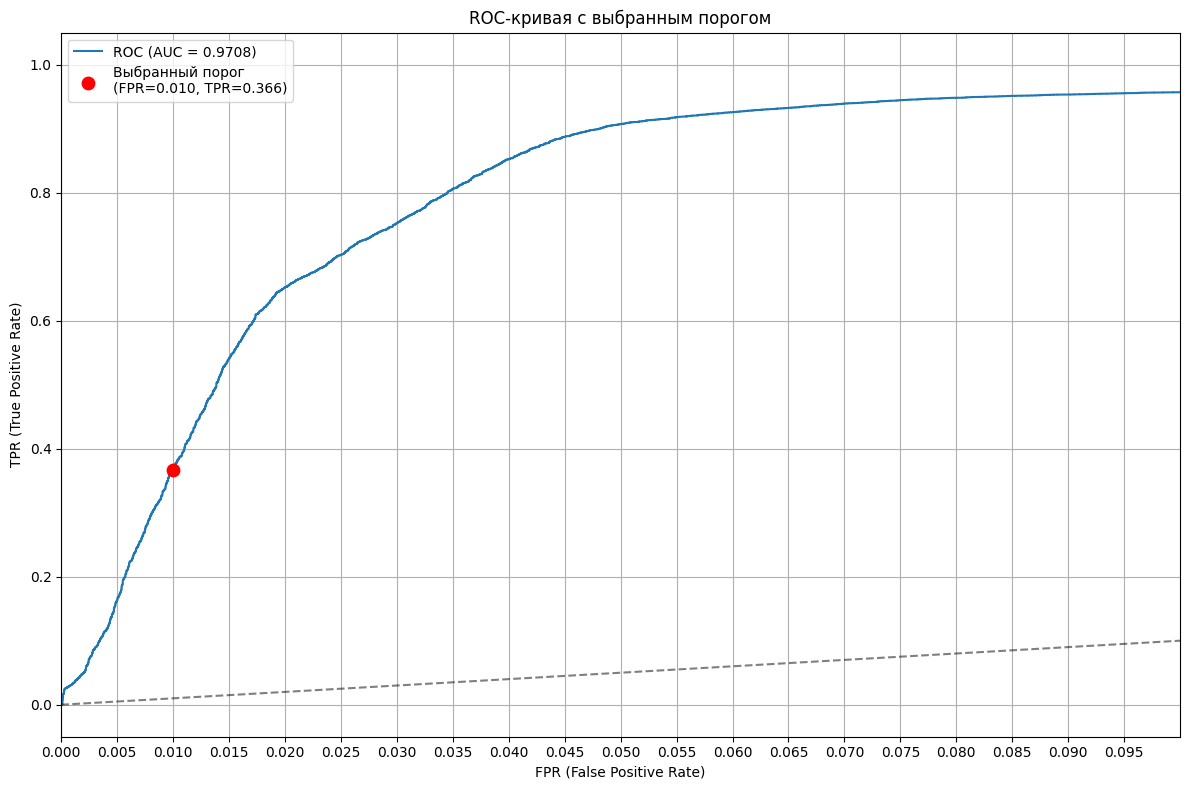

In [37]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# --- Предполагается, что эти переменные уже загружены в память ---
# ref_embeddings      # np.array, shape [R, 256]
# query_embeddings    # np.array, shape [Q, 256]
# true_labels         # np.array, shape [Q], значения: 1 (автоответчик), 0 (человек)

# --- 1. Вычислить максимальное сходство с базой ---
print("Вычисление сходства с базой эталонов...")
similarities = cosine_similarity(query_embeddings, ref_embeddings)  # [Q, R]
max_similarities = np.max(similarities, axis=1)  # [Q]

# --- 2. Построить ROC ---
fpr, tpr, thresholds = roc_curve(true_labels, max_similarities, pos_label=1)
roc_auc = auc(fpr, tpr)

# --- 3. Интерактивный выбор порога ---
print("\n" + "="*60)
print("Выберите способ выбора порога:")
print("  (1) Задать целевой FPR (например, 0.01 = 1%)")
print("  (2) Задать целевой TPR (например, 0.99 = 99%)")
print("  (3) Использовать EER (FAR = FRR)")
print("="*60)

# choice = input("Ваш выбор (1/2/3, по умолчанию: 3): ").strip() or "3"
choice = "1"


if choice == "1":
    # target_fpr = float(input("Введите желаемый FPR (0.0–1.0, например 0.01): "))
    target_fpr = 0.01
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) == 0:
        print("⚠️ Запрошенный FPR слишком низкий — используем минимально возможный.")
        chosen_idx = 0
    else:
        chosen_idx = idx[-1]  # последний, где FPR <= target
    chosen_threshold = thresholds[chosen_idx]
    actual_fpr = fpr[chosen_idx]
    actual_tpr = tpr[chosen_idx]
    print(f"\n✅ Выбран порог по FPR ≤ {target_fpr:.4f}")

elif choice == "2":
    # target_tpr = float(input("Введите желаемый TPR (0.0–1.0, например 0.99): "))
    target_tpr = 0.90
    idx = np.where(tpr >= target_tpr)[0]
    if len(idx) == 0:
        print("⚠️ Запрошенный TPR слишком высокий — используем максимально возможный.")
        chosen_idx = -1
    else:
        chosen_idx = idx[0]  # первый, где TPR >= target
    chosen_threshold = thresholds[chosen_idx]
    actual_fpr = fpr[chosen_idx]
    actual_tpr = tpr[chosen_idx]
    print(f"\n✅ Выбран порог по TPR ≥ {target_tpr:.4f}")

else:  # EER
    eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    chosen_threshold = interp1d(fpr, thresholds)(eer)
    actual_fpr = eer
    actual_tpr = 1 - eer
    print(f"\n✅ Используется порог по EER")

print(f"Выбранный порог сходства: {chosen_threshold:.6f}")
print(f"Достигнутый FPR: {actual_fpr:.6f} ({actual_fpr*100:.2f}%)")
print(f"Достигнутый TPR: {actual_tpr:.6f} ({actual_tpr*100:.2f}%)")

# --- 4. Метрики FAR / FRR ---
preds = (max_similarities >= chosen_threshold).astype(int)
tp = np.sum((preds == 1) & (true_labels == 1))
fp = np.sum((preds == 1) & (true_labels == 0))
tn = np.sum((preds == 0) & (true_labels == 0))
fn = np.sum((preds == 0) & (true_labels == 1))

far = fp / (fp + tn) if (fp + tn) > 0 else 0
frr = fn / (fn + tp) if (fn + tp) > 0 else 0

print(f"\n📌 Итоговые метрики:")
print(f"FAR (человек → автоответчик): {far:.6f}")
print(f"FRR (автоответчик → человек): {frr:.6f}")

# --- 5. Сохранить порог ---
with open("selected_threshold.txt", "w") as f:
    f.write(f"threshold={chosen_threshold:.6f}\n")
    f.write(f"FPR={actual_fpr:.6f}\n")
    f.write(f"TPR={actual_tpr:.6f}\n")
    f.write(f"FAR={far:.6f}\n")
    f.write(f"FRR={frr:.6f}\n")
print(f"\nПорог сохранён в: selected_threshold.txt")

# --- 6. График (опционально) ---
plt.figure(figsize=(12, 8))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
plt.scatter(actual_fpr, actual_tpr, color='red', s=80, zorder=5,
            label=f'Выбранный порог\n(FPR={actual_fpr:.3f}, TPR={actual_tpr:.3f})')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlim(0, 0.1)
plt.xticks(np.arange(0, 0.1, step=0.005))
plt.xlabel('FPR (False Positive Rate)')
plt.ylabel('TPR (True Positive Rate)')
plt.title('ROC-кривая с выбранным порогом')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Тестирование с разной длиной аудио

✅ Reference (база): 29374 файлов
✅ Запросы: 59816 файлов (21796 авто, 38020 люди)

⏳ Обработка длительности: 1.0 сек (8000 сэмплов)...
  → AUC: 0.8946 | EER: 0.1787 | FAR: 0.0750 | FRR: 0.3238

⏳ Обработка длительности: 1.5 сек (12000 сэмплов)...
  → AUC: 0.9436 | EER: 0.1139 | FAR: 0.0750 | FRR: 0.1817

⏳ Обработка длительности: 2.0 сек (16000 сэмплов)...
  → AUC: 0.9629 | EER: 0.0785 | FAR: 0.0750 | FRR: 0.0858

⏳ Обработка длительности: 2.5 сек (20000 сэмплов)...
  → AUC: 0.9690 | EER: 0.0688 | FAR: 0.0749 | FRR: 0.0562

⏳ Обработка длительности: 3.0 сек (24000 сэмплов)...
  → AUC: 0.9705 | EER: 0.0683 | FAR: 0.0750 | FRR: 0.0515

Длительность (сек) ROC-AUC    EER        FAR@7.5%FPR    FRR@7.5%FPR   
1.0                0.8946     0.1787     0.0750         0.3238        
1.5                0.9436     0.1139     0.0750         0.1817        
2.0                0.9629     0.0785     0.0750         0.0858        
2.5                0.9690     0.0688     0.0749         0.0562        
3.0

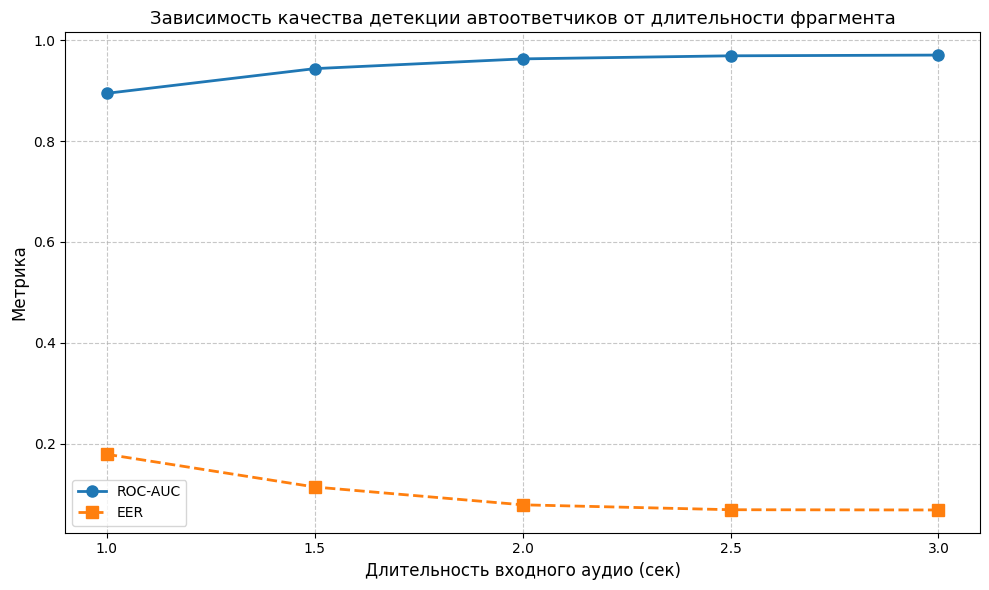

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd

# --- Укажите ваши параметры ---
SAMPLE_RATE = 8000
DATA_DIR = r'E:\python\train_smart_detect\train2'
BATCH_SIZE = 32

# Предполагается, что ref_embeddings и embedder_model уже загружены в глобальной области
# (как в вашем первоначальном скрипте)
REFERENCE_EMBEDDINGS = ref_embeddings  # [R, 256]
MODEL = embedder_model  # ваша модель

# Длительности для анализа (в секундах)
DURATIONS_SEC = [1.0, 1.5, 2.0, 2.5, 3.0]
DURATIONS_SAMPLES = [int(d * SAMPLE_RATE) for d in DURATIONS_SEC]

# --- Загрузка файлов ---
smart_dir = os.path.join(DATA_DIR, 'smart')
human_dir = os.path.join(DATA_DIR, 'human')

all_smart_files = [os.path.join(smart_dir, f) for f in os.listdir(smart_dir) if f.lower().endswith('.wav')]
all_human_files = [os.path.join(human_dir, f) for f in os.listdir(human_dir) if f.lower().endswith('.wav')]

# Reference: только *_001.wav из smart
reference_files = [f for f in all_smart_files if f.endswith('_001.wav')]
if len(reference_files) == 0:
    raise ValueError("Не найдено файлов *_001.wav в папке 'smart'!")

# Query: всё остальное
pos_queries = [f for f in all_smart_files if not f.endswith('_001.wav')]
neg_queries = all_human_files
all_queries = pos_queries + neg_queries
true_labels = np.array([1] * len(pos_queries) + [0] * len(neg_queries))

print(f"✅ Reference (база): {len(reference_files)} файлов")
print(f"✅ Запросы: {len(all_queries)} файлов ({len(pos_queries)} авто, {len(neg_queries)} люди)")

# --- Функция загрузки с фиксированной длиной от начала ---
def load_audio_to_fixed_length(file_path, target_length):
    """Загружает аудио, берёт начало, обрезает или дополняет до target_length."""
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.where(tf.math.is_finite(audio), audio, 0.0)
    audio = tf.clip_by_value(audio, -1.0, 1.0)

    current_len = tf.shape(audio)[0]
    if current_len >= target_length:
        # Обрезаем до target_length (берём начало!)
        audio = audio[:target_length]
    else:
        # Дополняем нулями
        pad_len = target_length - current_len
        audio = tf.pad(audio, [[0, pad_len]], constant_values=0.0)
    return audio

def get_embeddings_for_duration(file_paths, model, target_length, batch_size=BATCH_SIZE):
    embeddings = []
    for i in range(0, len(file_paths), batch_size):
        batch = file_paths[i:i + batch_size]
        audios = tf.stack([load_audio_to_fixed_length(fp, target_length) for fp in batch])
        embs = model(audios, training=False).numpy()
        embeddings.append(embs)
    return np.vstack(embeddings)

# --- Основной цикл по длительностям ---
results = []

for dur_sec, dur_samples in zip(DURATIONS_SEC, DURATIONS_SAMPLES):
    print(f"\n⏳ Обработка длительности: {dur_sec:.1f} сек ({dur_samples} сэмплов)...")

    # Генерация эмбеддингов для запросов (с обрезкой/дополнением)
    query_embs = get_embeddings_for_duration(all_queries, MODEL, dur_samples, BATCH_SIZE)

    # Сходство с фиксированной reference-базой (полные *_001.wav)
    sims = cosine_similarity(query_embs, REFERENCE_EMBEDDINGS)  # [Q, R]
    max_sims = np.max(sims, axis=1)  # [Q]

    # ROC-AUC
    fpr, tpr, thresholds = roc_curve(true_labels, max_sims, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # EER
    try:
        eer = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0.0, 1.0)
        eer_thresh = float(interp1d(fpr, thresholds)(eer))
    except:
        eer, eer_thresh = np.nan, np.nan

    # FAR/FRR при целевом FPR = 7.5% (как в вашем примере)
    target_fpr = 0.05
    idx = np.where(fpr <= target_fpr)[0]
    if len(idx) > 0:
        chosen_idx = idx[-1]
        thresh = thresholds[chosen_idx]
        preds = (max_sims >= thresh).astype(int)
        tp = np.sum((preds == 1) & (true_labels == 1))
        fp = np.sum((preds == 1) & (true_labels == 0))
        tn = np.sum((preds == 0) & (true_labels == 0))
        fn = np.sum((preds == 0) & (true_labels == 1))
        far = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        frr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
        actual_fpr = fpr[chosen_idx]
        actual_tpr = tpr[chosen_idx]
    else:
        far = frr = actual_fpr = actual_tpr = np.nan

    results.append({
        'duration_sec': dur_sec,
        'roc_auc': roc_auc,
        'eer': eer,
        'far_at_fpr_7.5%': far,
        'frr_at_fpr_7.5%': frr,
        'actual_fpr': actual_fpr,
        'actual_tpr': actual_tpr,
    })

    print(f"  → AUC: {roc_auc:.4f} | EER: {eer:.4f} | FAR: {far:.4f} | FRR: {frr:.4f}")

# --- Вывод итоговой таблицы ---
print("\n" + "="*90)
print(f"{'Длительность (сек)':<18} {'ROC-AUC':<10} {'EER':<10} {'FAR@7.5%FPR':<14} {'FRR@7.5%FPR':<14}")
print("="*90)
for r in results:
    print(f"{r['duration_sec']:<18} {r['roc_auc']:<10.4f} {r['eer']:<10.4f} "
          f"{r['far_at_fpr_7.5%']:<14.4f} {r['frr_at_fpr_7.5%']:<14.4f}")

# --- График ---
durs = [r['duration_sec'] for r in results]
aucs = [r['roc_auc'] for r in results]
eers = [r['eer'] for r in results]

plt.figure(figsize=(10, 6))
plt.plot(durs, aucs, 'o-', label='ROC-AUC', linewidth=2, markersize=8)
plt.plot(durs, eers, 's--', label='EER', linewidth=2, markersize=8)
plt.xlabel('Длительность входного аудио (сек)', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.title('Зависимость качества детекции автоответчиков от длительности фрагмента', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(durs)
plt.tight_layout()
plt.show()

# --- Сохранение результатов ---
# df = pd.DataFrame(results) 
# df.to_csv("audio_duration_ab_test_results.csv", index=False, float_format="%.6f")
# print(f"\n✅ Результаты сохранены в 'audio_duration_ab_test_results.csv'")

✅ Reference: 29374, Queries: 59816

⏳ Тест для 1.0 сек (FAR ≤ 1.0%)...
  → Порог: 0.9421 | FAR: 0.0100 | FRR: 0.9318 | Precision: 0.7965

⏳ Тест для 1.5 сек (FAR ≤ 1.0%)...
  → Порог: 0.9505 | FAR: 0.0100 | FRR: 0.8829 | Precision: 0.8704

⏳ Тест для 2.0 сек (FAR ≤ 1.0%)...
  → Порог: 0.9549 | FAR: 0.0100 | FRR: 0.8002 | Precision: 0.9197

⏳ Тест для 2.5 сек (FAR ≤ 1.0%)...
  → Порог: 0.9595 | FAR: 0.0100 | FRR: 0.7312 | Precision: 0.9391

⏳ Тест для 3.0 сек (FAR ≤ 1.0%)...
  → Порог: 0.9658 | FAR: 0.0100 | FRR: 0.7322 | Precision: 0.9389

Длит.  Порог    FAR      FRR      Precision   TP       FP      
1.0    0.9421   0.0100   0.9318   0.7965      1487     380     
1.5    0.9505   0.0100   0.8829   0.8704      2552     380     
2.0    0.9549   0.0100   0.8002   0.9197      4355     380     
2.5    0.9595   0.0100   0.7312   0.9391      5858     380     
3.0    0.9658   0.0100   0.7322   0.9389      5837     380     


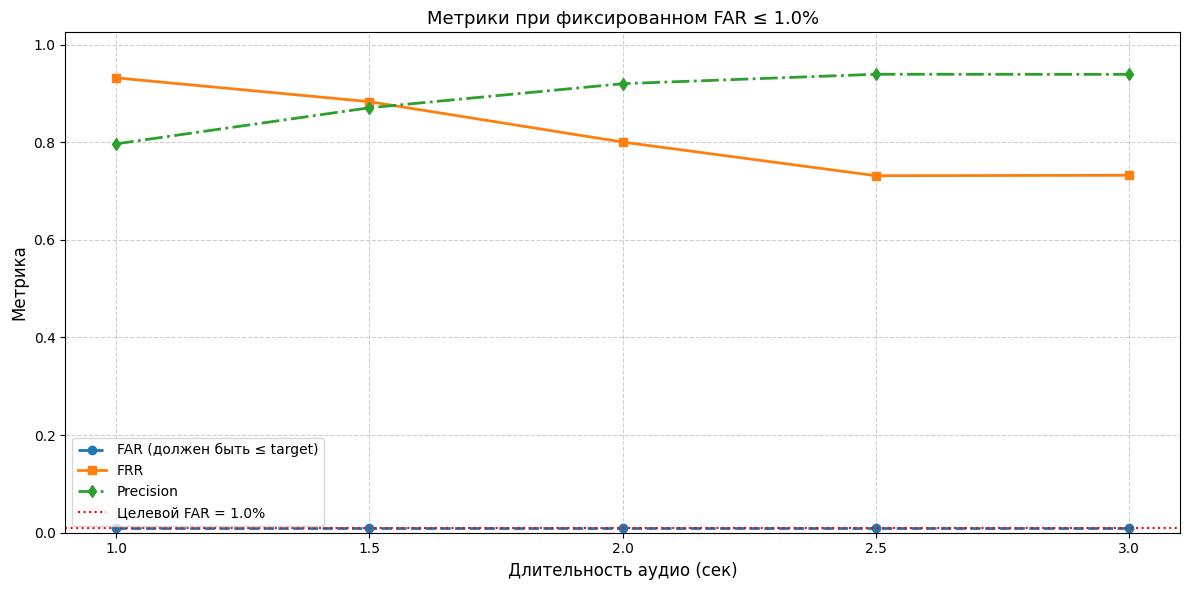

In [21]:
import os
import numpy as np
import tensorflow as tf
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pandas as pd

# --- Настройки ---
SAMPLE_RATE = 8000
DATA_DIR = r'E:\python\train_smart_detect\train2'
BATCH_SIZE = 32

# Уже загружены:
REFERENCE_EMBEDDINGS = ref_embeddings  # [R, 256]
MODEL = embedder_model

# Длительности
DURATIONS_SEC = [1.0, 1.5, 2.0, 2.5, 3.0]
DURATIONS_SAMPLES = [int(d * SAMPLE_RATE) for d in DURATIONS_SEC]

# Целевой FAR (выберите один)
TARGET_FAR = 0.01   # 1% — рекомендуется начать с этого
# TARGET_FAR = 0.005  # 0.5% — если нужно ещё строже

# --- Загрузка файлов (как у вас) ---
smart_dir = os.path.join(DATA_DIR, 'smart')
human_dir = os.path.join(DATA_DIR, 'human')

all_smart_files = [os.path.join(smart_dir, f) for f in os.listdir(smart_dir) if f.lower().endswith('.wav')]
all_human_files = [os.path.join(human_dir, f) for f in os.listdir(human_dir) if f.lower().endswith('.wav')]

reference_files = [f for f in all_smart_files if f.endswith('_001.wav')]
pos_queries = [f for f in all_smart_files if not f.endswith('_001.wav')]
neg_queries = all_human_files
all_queries = pos_queries + neg_queries
true_labels = np.array([1] * len(pos_queries) + [0] * len(neg_queries))

print(f"✅ Reference: {len(reference_files)}, Queries: {len(all_queries)}")

# --- Функции загрузки (как раньше) ---
def load_audio_to_fixed_length(file_path, target_length):
    audio_binary = tf.io.read_file(file_path)
    audio, _ = tf.audio.decode_wav(audio_binary, desired_channels=1)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.where(tf.math.is_finite(audio), audio, 0.0)
    audio = tf.clip_by_value(audio, -1.0, 1.0)
    current_len = tf.shape(audio)[0]
    if current_len >= target_length:
        audio = audio[:target_length]
    else:
        pad_len = target_length - current_len
        audio = tf.pad(audio, [[0, pad_len]], constant_values=0.0)
    return audio

def get_embeddings_for_duration(file_paths, model, target_length, batch_size=BATCH_SIZE):
    embeddings = []
    for i in range(0, len(file_paths), batch_size):
        batch = file_paths[i:i + batch_size]
        audios = tf.stack([load_audio_to_fixed_length(fp, target_length) for fp in batch])
        embs = model(audios, training=False).numpy()
        embeddings.append(embs)
    return np.vstack(embeddings)

# --- Основной цикл ---
results = []

for dur_sec, dur_samples in zip(DURATIONS_SEC, DURATIONS_SAMPLES):
    print(f"\n⏳ Тест для {dur_sec:.1f} сек (FAR ≤ {TARGET_FAR:.1%})...")

    # Эмбеддинги запросов
    query_embs = get_embeddings_for_duration(all_queries, MODEL, dur_samples, BATCH_SIZE)
    
    # Макс. сходство с базой
    sims = cosine_similarity(query_embs, REFERENCE_EMBEDDINGS)
    max_sims = np.max(sims, axis=1)

    # Сортируем по сходству (для точного подбора порога)
    sorted_indices = np.argsort(max_sims)[::-1]  # от высокого к низкому
    sorted_sims = max_sims[sorted_indices]
    sorted_labels = true_labels[sorted_indices]

    # Ищем порог, при котором FAR ≤ TARGET_FAR
    n_neg = len(neg_queries)  # количество людей (negatives)
    max_fp_allowed = int(np.floor(TARGET_FAR * n_neg))  # макс. допустимых FP

    # Сканируем пороги от самого строгого (высокое сходство) к мягким
    best_idx = 0
    fp_count = 0
    for i, label in enumerate(sorted_labels):
        if label == 0:  # это человек → потенциальный FP
            fp_count += 1
        if fp_count > max_fp_allowed:
            best_idx = i  # порог должен быть ВЫШЕ текущего значения
            break
    else:
        best_idx = len(sorted_labels)  # можно принимать всех

    # Порог: минимальное сходство, при котором FP ≤ max_fp_allowed
    if best_idx == 0:
        threshold = 1.0  # ничего не принимаем
        tp = fp = 0
    else:
        threshold = sorted_sims[best_idx - 1]  # последнее принятое значение
        # Все с сходством >= threshold — принимаются как автоответчики
        preds = (max_sims >= threshold).astype(int)
        tp = np.sum((preds == 1) & (true_labels == 1))
        fp = np.sum((preds == 1) & (true_labels == 0))

    tn = len(neg_queries) - fp
    fn = len(pos_queries) - tp

    far = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    frr = fn / (fn + tp) if (fn + tp) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    results.append({
        'duration_sec': dur_sec,
        'threshold': threshold,
        'far': far,
        'frr': frr,
        'precision': precision,
        'accuracy': accuracy,
        'tp': tp,
        'fp': fp,
        'fn': fn,
        'tn': tn,
    })

    print(f"  → Порог: {threshold:.4f} | FAR: {far:.4f} | FRR: {frr:.4f} | Precision: {precision:.4f}")

# --- Вывод таблицы ---
print("\n" + "="*100)
print(f"{'Длит.':<6} {'Порог':<8} {'FAR':<8} {'FRR':<8} {'Precision':<11} {'TP':<8} {'FP':<8}")
print("="*100)
for r in results:
    print(f"{r['duration_sec']:<6} {r['threshold']:<8.4f} {r['far']:<8.4f} {r['frr']:<8.4f} "
          f"{r['precision']:<11.4f} {r['tp']:<8} {r['fp']:<8}")

# --- График: FAR/FRR/Precision vs Duration ---
durs = [r['duration_sec'] for r in results]
fars = [r['far'] for r in results]
frrs = [r['frr'] for r in results]
precisions = [r['precision'] for r in results]

plt.figure(figsize=(12, 6))
plt.plot(durs, fars, 'o--', label='FAR (должен быть ≤ target)', linewidth=2)
plt.plot(durs, frrs, 's-', label='FRR', linewidth=2)
plt.plot(durs, precisions, 'd-.', label='Precision', linewidth=2)
plt.axhline(y=TARGET_FAR, color='red', linestyle=':', label=f'Целевой FAR = {TARGET_FAR:.1%}')
plt.xlabel('Длительность аудио (сек)', fontsize=12)
plt.ylabel('Метрика', fontsize=12)
plt.title(f'Метрики при фиксированном FAR ≤ {TARGET_FAR:.1%}', fontsize=13)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(durs)
plt.ylim(0, max(0.5, max(frrs) * 1.1))
plt.tight_layout()
plt.show()

# --- Сохранение ---
# df = pd.DataFrame(results)
# output_file = f"fixed_far_{int(TARGET_FAR*1000)}_per_mille_results.csv"
# df.to_csv(output_file, index=False, float_format="%.6f")
# print(f"\n✅ Результаты сохранены в '{output_file}'")

#### Сохранение модели в ONNX

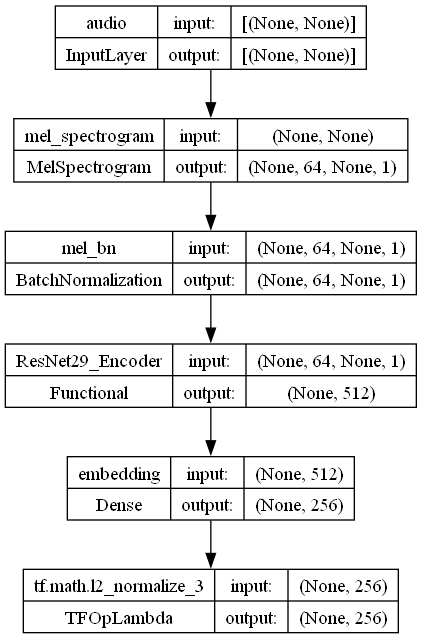

In [86]:
tf.keras.utils.plot_model(
    embedder_model,
    to_file='resnet29_encoder.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',  # 'TB' = top to bottom, 'LR' = left to right
    expand_nested=False,
    dpi=96
)

In [ ]:
# extract_submodel.py
import tensorflow as tf
from tensorflow import keras


# Найдем слой, который идёт после MelSpectrogram — это mel_bn
mel_bn_layer = embedder_model.get_layer("mel_bn")

# Создаём новую модель, начинающуюся с входа mel_bn
submodel_input = mel_bn_layer.input  # Это выход MelSpectrogram
submodel_output = embedder_model.output  # Это L2-normalized embedding

# Явно создаём именованный выходной слой
output_layer = tf.keras.layers.Lambda(lambda x: x, name="speaker_embedding")(submodel_output)

submodel = tf.keras.Model(inputs=submodel_input, outputs=output_layer, name="SpeakerEmbedder")

# Проверяем
print("Submodel input shape:", submodel.input_shape)  # Должно быть (None, 64, None, 1)
print("Submodel output shape:", submodel.output_shape)  # (None, 256)

# Сохраняем веса
# submodel.save_weights("submodel_weights.h5")

Submodel input shape: (None, 64, None, 1)
Submodel output shape: (None, 256)


In [94]:
import tf2onnx

# Вход: [batch, 64, time, 1]
input_signature = tf.TensorSpec((None, 64, None, 1), tf.float32, name="MEL_INPUT")

onnx_model, _ = tf2onnx.convert.from_keras(
    submodel,
    input_signature=[input_signature],
    opset=17
)

with open("speaker_embedder.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [95]:
import onnx
model_on = onnx.load("speaker_embedder.onnx")
inp = model_on.graph.input[0]
print("Input name:", inp.name)
print("Input shape:", [d.dim_value if d.dim_value != 0 else -1 for d in inp.type.tensor_type.shape.dim])

Input name: MEL_INPUT
Input shape: [-1, 64, -1, 1]


In [96]:
for out in model_on.graph.output:
    shape = [d.dim_value if d.dim_value != 0 else -1 for d in out.type.tensor_type.shape.dim]
    print(f"  {out.name} -> {shape}")

  speaker_embedding -> [-1, 256]
